### Data Science Salaries 2024 

## Data Cleaning

The dataset used is the [**Data Science Salaries 2024**](https://www.kaggle.com/datasets/sazidthe1/data-science-salaries), a dataset containing informations such as salary, work model, employment type and more about data scientists in all of the world. The author **Sazidul Islam** has done a great job in cleaning the data, but some minor changes are needed.

First of all, let"s import all the libraries I are gonna use.

In [1]:
#importing libraries

from os import getcwd #to get the working directory through getcwd

from pandas import * #to manipulate dataframes

import geopandas as gpd #for choropleth maps

from plotnine import *
from numpy import *
from plotnine.stats import * #for data visualization and data transformation

from statistics import * #to get all of the statistical functions needed

from thefuzz import process #for fuzzy string matching

from owid.catalog import charts # Import Our World in Data API library

I downloaded the data and moved it into the working directory. It is in the .csv format, so I"m gonna use the function read_csv to read the file and store it in a pandas dataframe.

In [2]:
path_to_data = getcwd() + r"\data_science_salaries.csv" #setting path to data

data = read_csv(path_to_data, sep = ",") #creating pandas dataframe

print("Number of rows: ", len(data)) #printing number of rows

Number of rows:  6599


In [3]:
data.head() #printing quick view of data

,job_title,experience_level,employment_type,work_models,work_year,employee_residence,salary,salary_currency,salary_in_usd,company_location,company_size
0,Data Engineer,Mid-level,Full-time,Remote,2024,United States,148100,USD,148100,United States,Medium
1,Data Engineer,Mid-level,Full-time,Remote,2024,United States,98700,USD,98700,United States,Medium
2,Data Scientist,Senior-level,Full-time,Remote,2024,United States,140032,USD,140032,United States,Medium
3,Data Scientist,Senior-level,Full-time,Remote,2024,United States,100022,USD,100022,United States,Medium
4,BI Developer,Mid-level,Full-time,On-site,2024,United States,120000,USD,120000,United States,Medium


The number of rows is 6599, a really big amount of data. First thing that comes into my eyes, are the capitalized first letters of every word, and the diversity in the job_title column.

In [4]:
data["job_title"].value_counts() #printing absolute frequencies of job titles

job_title
Data Engineer                      1307
Data Scientist                     1243
Data Analyst                        910
Machine Learning Engineer           629
Analytics Engineer                  246
                                   ... 
Data Science Tech Lead                1
Staff Machine Learning Engineer       1
Cloud Data Architect                  1
Marketing Data Engineer               1
Sales Data Analyst                    1
Name: count, Length: 132, dtype: int64

Since the data job market it's relatively young, job titles aren't as fixed as in other industries. This means that there is still a plethora of job titles that describe slightly different positions.

For the sake of simplicity, I’ll focus on the four most commonly recognized titles that could be seen as industry standards:

1. **Data Analyst**, who analyzes data in order to provide business insights.
2. **Data Scientist**, who builds models to predict future outcomes based on historical data.
3. **Machine Learning Engineer**, who implements already existing machine learning algorithms to business problems.
4. **Data Engineer**, who builds and maintains the infrastructure for data processing.

In [5]:
for x in data:
    if data[x].dtype == "object":
        data[x] = data[x].str.lower() #lower casing all strings.
data.head()

,job_title,experience_level,employment_type,work_models,work_year,employee_residence,salary,salary_currency,salary_in_usd,company_location,company_size
0,data engineer,mid-level,full-time,remote,2024,united states,148100,usd,148100,united states,medium
1,data engineer,mid-level,full-time,remote,2024,united states,98700,usd,98700,united states,medium
2,data scientist,senior-level,full-time,remote,2024,united states,140032,usd,140032,united states,medium
3,data scientist,senior-level,full-time,remote,2024,united states,100022,usd,100022,united states,medium
4,bi developer,mid-level,full-time,on-site,2024,united states,120000,usd,120000,united states,medium


In [6]:
jobs_to_keep = ["data engineer", "data scientist", "data analyst", "machine learning engineer"] #defining jobs to keep
data = data[data["job_title"].isin(jobs_to_keep)] #boolean indexing. data["job_title"].isin(jobs_to_keep) returns an array of False or True if the job title is in jobs_to_keep.
unique(data["job_title"])

array(['data analyst', 'data engineer', 'data scientist',
       'machine learning engineer'], dtype=object)

In [7]:
#pandas stores string values under the "ObjectType" 
print(type(data["job_title"].dtype))
print(type(data["work_models"].dtype))


<class 'numpy.dtypes.ObjectDType'>
<class 'numpy.dtypes.ObjectDType'>


As we can see, I have 4089 rows left, which are enough for our purpose. I don"t like the "-level" in every experience_level value, so I"m gonna delete it.

In [8]:
data["experience_level"] = data["experience_level"].str.replace("-level","") #removing "-level" from column experience_level

In the data set there are 127 occurrences with experience_level "executive". I will focus on the three levels below it: "senior", "mid-level", and "junior".

In [9]:
print(len(data[data['experience_level'] == "executive"]))
data = data[data['experience_level'] != "executive"] #dropping executive occurrences

128


The dataset has a number of categorical variables. Let's convert those columns to the pandas Categorical type.

In [10]:
data["job_title"] = Categorical(data["job_title"])

ordered_experience_variable = ["entry", "mid", "senior"]
data["experience_level"] = Categorical(data["experience_level"],ordered = True, categories=ordered_experience_variable)

data["employment_type"] = Categorical(data["employment_type"])

ordered_work_models = ["on-site","hybrid","remote"]
data["work_models"] = Categorical(data["work_models"], ordered = True,categories = ordered_work_models)

ordered_size = ["small", "medium", "large"]
data["company_size"] = Categorical(data["company_size"], ordered = True, categories = ordered_size)

#casting categories to categorical data type, ordered if needed

data.dtypes

job_title             category
experience_level      category
employment_type       category
work_models           category
work_year                int64
employee_residence      object
salary                   int64
salary_currency         object
salary_in_usd            int64
company_location        object
company_size          category
dtype: object

For the sake of having a sufficient number of occurrences in order to get meaningful informations about the dataset, I will drop every country that doesn't have at least 10 occurrences in the dataset.

In [11]:
print("N of countries before:",len(unique(data["company_location"])))
print("N of rows before:",len((data)))
counts = data['company_location'].value_counts() #getting absolute frequencies of countries

valid_countries = counts[counts >= 5].index #getting the countries with at least 10 occurrences 

data = data[data['company_location'].isin(valid_countries)] #slicing data with value company location in valid_countries

print("N of countries after:",len(unique(data["company_location"])))
print("N of rows after:",len((data)))

N of countries before: 57
N of rows before: 3961
N of countries after: 21
N of rows after: 3893


Now, I need to import geometric data about countries in order to draw maps later on. I will download the dataset from [Natural Earth](https://www.naturalearthdata.com/) and load it into a GeoDataFrame and then a join will be performed with the main DataFrame on the country column.

In [12]:
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"

gdf = gpd.read_file(url)
gdf = gdf.loc[:,["ADMIN","geometry"]] #slice just the two columns I'm interested in
gdf.head()

,ADMIN,geometry
0,Fiji,"MULTIPOLYGON (((180 -16.06713, 180 -16.55522, ..."
1,United Republic of Tanzania,"POLYGON ((33.90371 -0.95, 34.07262 -1.05982, 3..."
2,Western Sahara,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,Canada,"MULTIPOLYGON (((-122.84 49, -122.97421 49.0025..."
4,United States of America,"MULTIPOLYGON (((-122.84 49, -120 49, -117.0312..."


Since the countries name in the dataset might not match exactly with the names in the Natural Earth dataset, I will use the `thefuzz` library to perform **fuzzy matching** on the country names. It uses Levenshtein Distance (minimum number of single-character edits) to calculate the differences between two input sequences.


In [13]:
data["country"] = data["company_location"].apply(lambda x: process.extractOne(x, gdf["ADMIN"])[0]) #matching the countries names

In [14]:
for x in unique(data["company_location"]):
    a = process.extractOne(x,gdf["ADMIN"])[0] 
    print(x,"|",a) #checking if the matched names are correct

argentina | Argentina
australia | Australia
brazil | Brazil
canada | Canada
colombia | Colombia
estonia | Estonia
france | France
germany | Germany
greece | Greece
india | India
ireland | Ireland
italy | Italy
latvia | Latvia
mexico | Mexico
netherlands | Netherlands
poland | Poland
portugal | Portugal
slovenia | Slovenia
spain | Spain
united kingdom | United Kingdom
united states | United States of America


In [15]:
data.drop(["company_location","salary_currency"], axis = 1, inplace = True) #dropping ADMIN and company_location columns

In [16]:
ppp_dataset = charts.get_data(r"https://ourworldindata.org/grapher/ppp-conversion-factor-for-private-consumption") # Get PPP index (Purchase Power Parity index) dataset
ppp_dataset = ppp_dataset[ppp_dataset ["years"] == 2023] # Keep only 2023 data
ppp_dataset = ppp_dataset[~ppp_dataset["entities"].isin(["Saint Lucia", "Singapore","Iceland","Austria"])].reset_index() # Remove specific countries to improve later matching
data = data[data["country"] != "Argentina"].reset_index() # Remove Argentina as it is not in the PPP dataset due to the rampaging inflation in those years

In [17]:
studied_countries=unique(data["country"])
print(studied_countries)

['Australia' 'Brazil' 'Canada' 'Colombia' 'Estonia' 'France' 'Germany'
 'Greece' 'India' 'Ireland' 'Italy' 'Latvia' 'Mexico' 'Netherlands'
 'Poland' 'Portugal' 'Slovenia' 'Spain' 'United Kingdom'
 'United States of America']


In [18]:
for x in unique(ppp_dataset["entities"]):
    try:
        a = process.extractOne(x, unique(data["country"]), score_cutoff=90)[0]
        print(x, "|", a)
    except Exception as e:
        print(x, "|", None)

Albania | None
Algeria | None
Angola | None
Antigua and Barbuda | None
Armenia | None
Australia | Australia
Azerbaijan | None
Bahamas | None
Bahrain | None
Bangladesh | None
Belarus | None
Belgium | None
Belize | None
Benin | None
Bhutan | None
Bolivia | None
Bosnia and Herzegovina | None
Botswana | None
Brazil | Brazil
Brunei | None
Bulgaria | None
Burkina Faso | None
Burundi | None
Cambodia | None
Cameroon | None
Canada | Canada
Cape Verde | None
Central African Republic | None
Chad | None
Chile | None
China | None
Colombia | Colombia
Congo | None
Costa Rica | None
Cote d'Ivoire | None
Croatia | None
Cyprus | None
Czechia | None
Denmark | None
Djibouti | None
Dominica | None
Dominican Republic | None
East Timor | None
Ecuador | None
Egypt | None
El Salvador | None
Estonia | Estonia
Ethiopia | None
Fiji | None
Finland | None
France | France
Gabon | None
Gambia | None
Georgia | None
Germany | Germany
Ghana | None
Greece | Greece
Grenada | None
Guinea | None
Guyana | None
Haiti | None
H

In [19]:
ppp_dataset["entities"] = ppp_dataset["entities"].apply(lambda x: process.extractOne(x, data["country"], score_cutoff=85)[0] if process.extractOne(x, data["country"], score_cutoff=85) is not None else None)

In [ ]:
data = merge(data, ppp_dataset.loc[:,["entities","ppp_conversion_factor_for_private_consumption"]], left_on = "country", right_on = "entities", how = "left")
data.drop(columns = ["entities"],axis = 1, inplace = True)

In [ ]:
data["salary_in_usd"] = data["salary"] / data["ppp_conversion_factor_for_private_consumption"]

Now let"s check for missing values.

In [22]:
for x in data:
    if data[x].hasnans == "True":
        print(x,":",data[x].hasnans)
#hasnans is an attribute of pandas.Series (pandas columns) that returns False if the columns doesn"t have any Nan or True if it has at least one.

No NaN values in our data. We can go on with our visualizations

## Data Visualization

Let"s set the default theme and colors for our visualizations.

In [23]:
cols = {"data analyst":"#C44E52", "data engineer":"#E5C07B", "data scientist":"#4C72B0", "machine learning engineer":"#55A868"}
theme_set(theme_538())
theme(figure_size = (10,6))

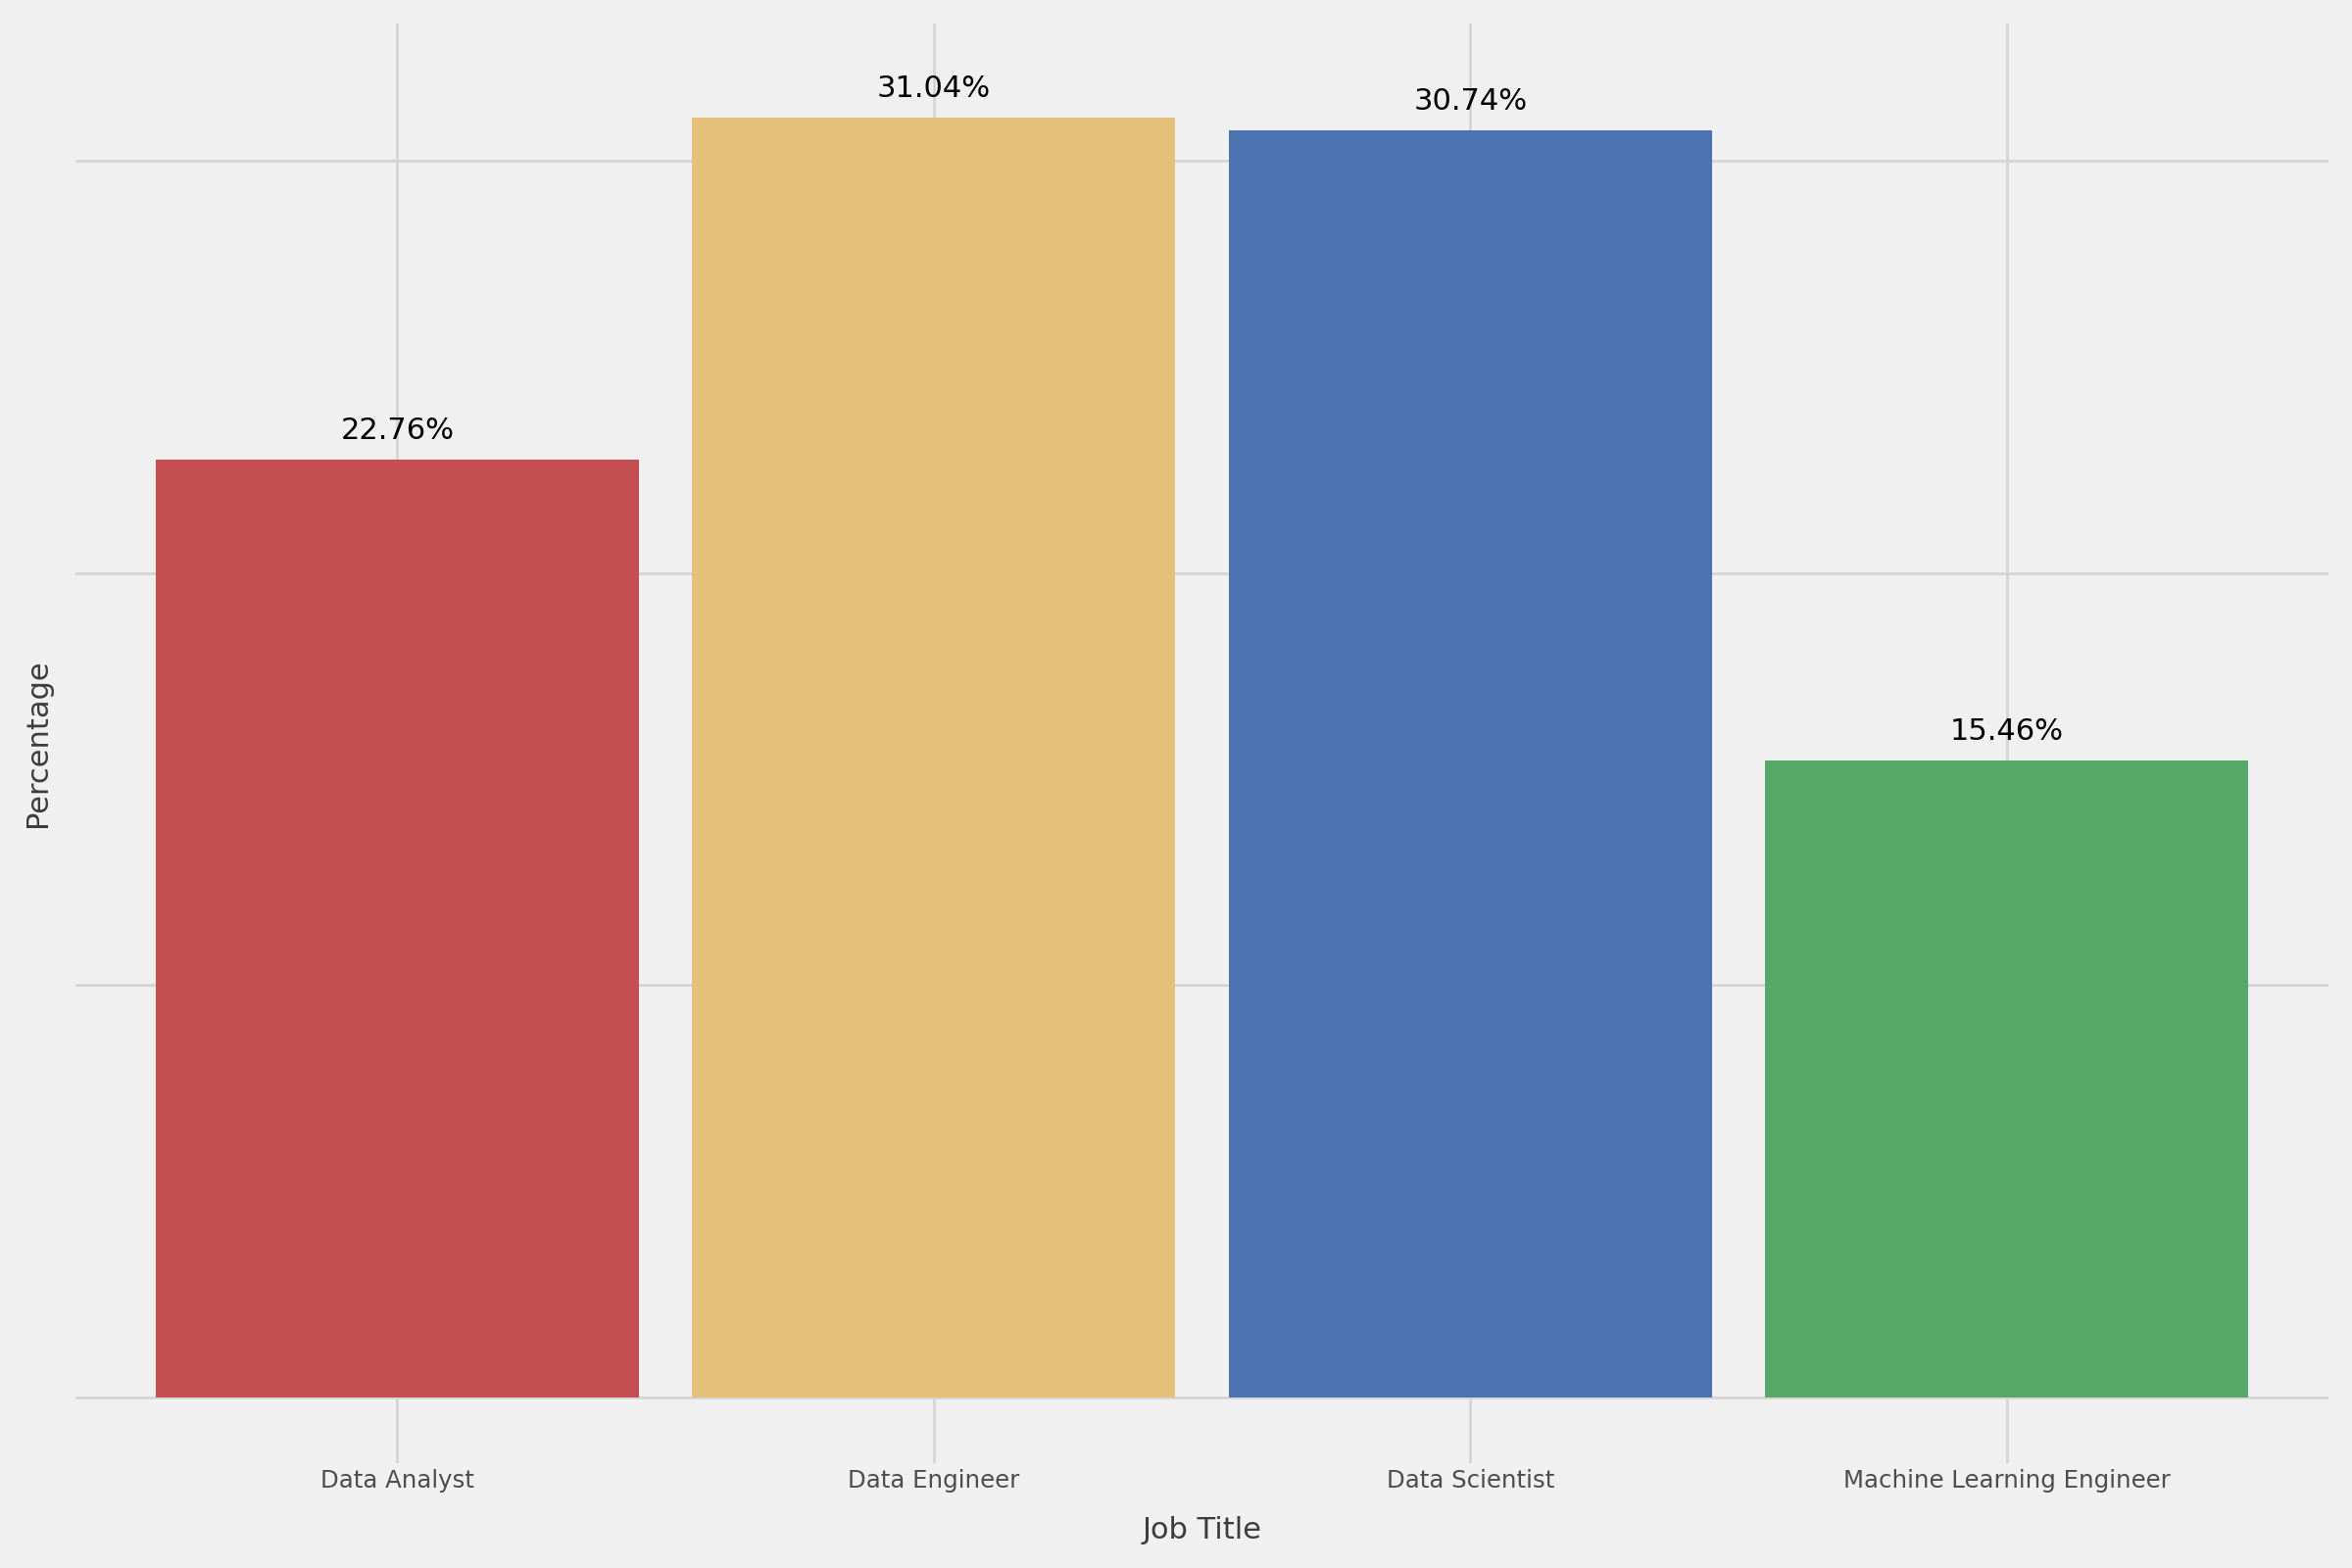

In [24]:
(
    ggplot(data, aes(x = "job_title")) # Map job_title to x-axis
    + geom_bar(aes(y = after_stat("count / sum(count) *100"), fill = "job_title")) # Create bar chart and computing percentage
    + geom_text(aes(y = after_stat("prop*100"), label = after_stat("prop*100"),group = 1),stat = "count", format_string = "{:.2f}%",nudge_y = 0.7) # Add text labels (percentages) over bars
    + scale_fill_manual(cols, guide = None) # Custom fill colors and remove legend
    + scale_x_discrete(labels = lambda l: [x.title() for x in l]) # Capitalize x-axis breaks labels
    + labs(y = "Percentage", x = "Job Title") # Add x and y axis labels
    + theme(axis_text_y=element_blank(),axis_ticks_y=element_blank(), figure_size = (12,8)) # Remove y-axis text and ticks and increase figure size
)

In [25]:
job_title_prop = data.groupby(["employee_residence", "job_title"]).size().reset_index(name = "count") # Get a grouped by employee residence and job title dataframe
job_title_prop.drop(["count"], axis=1, inplace=True) # Drop "count" column
job_title_prop["percentage"] = data.groupby(["employee_residence", "job_title"]).size().groupby("employee_residence").apply(lambda x: round(x / x.sum() * 100, 2)).reset_index(drop = True)
job_title_prop = job_title_prop[job_title_prop["percentage"] > 0]

2025-09-02 17:52:57 [warning  ] The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning. category=FutureWarning filename=C:\Users\Marco\AppData\Local\Temp\ipykernel_16708\601909.py lineno=1
2025-09-02 17:52:57 [warning  ] The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning. category=FutureWarning filename=C:\Users\Marco\AppData\Local\Temp\ipykernel_16708\601909.py lineno=3


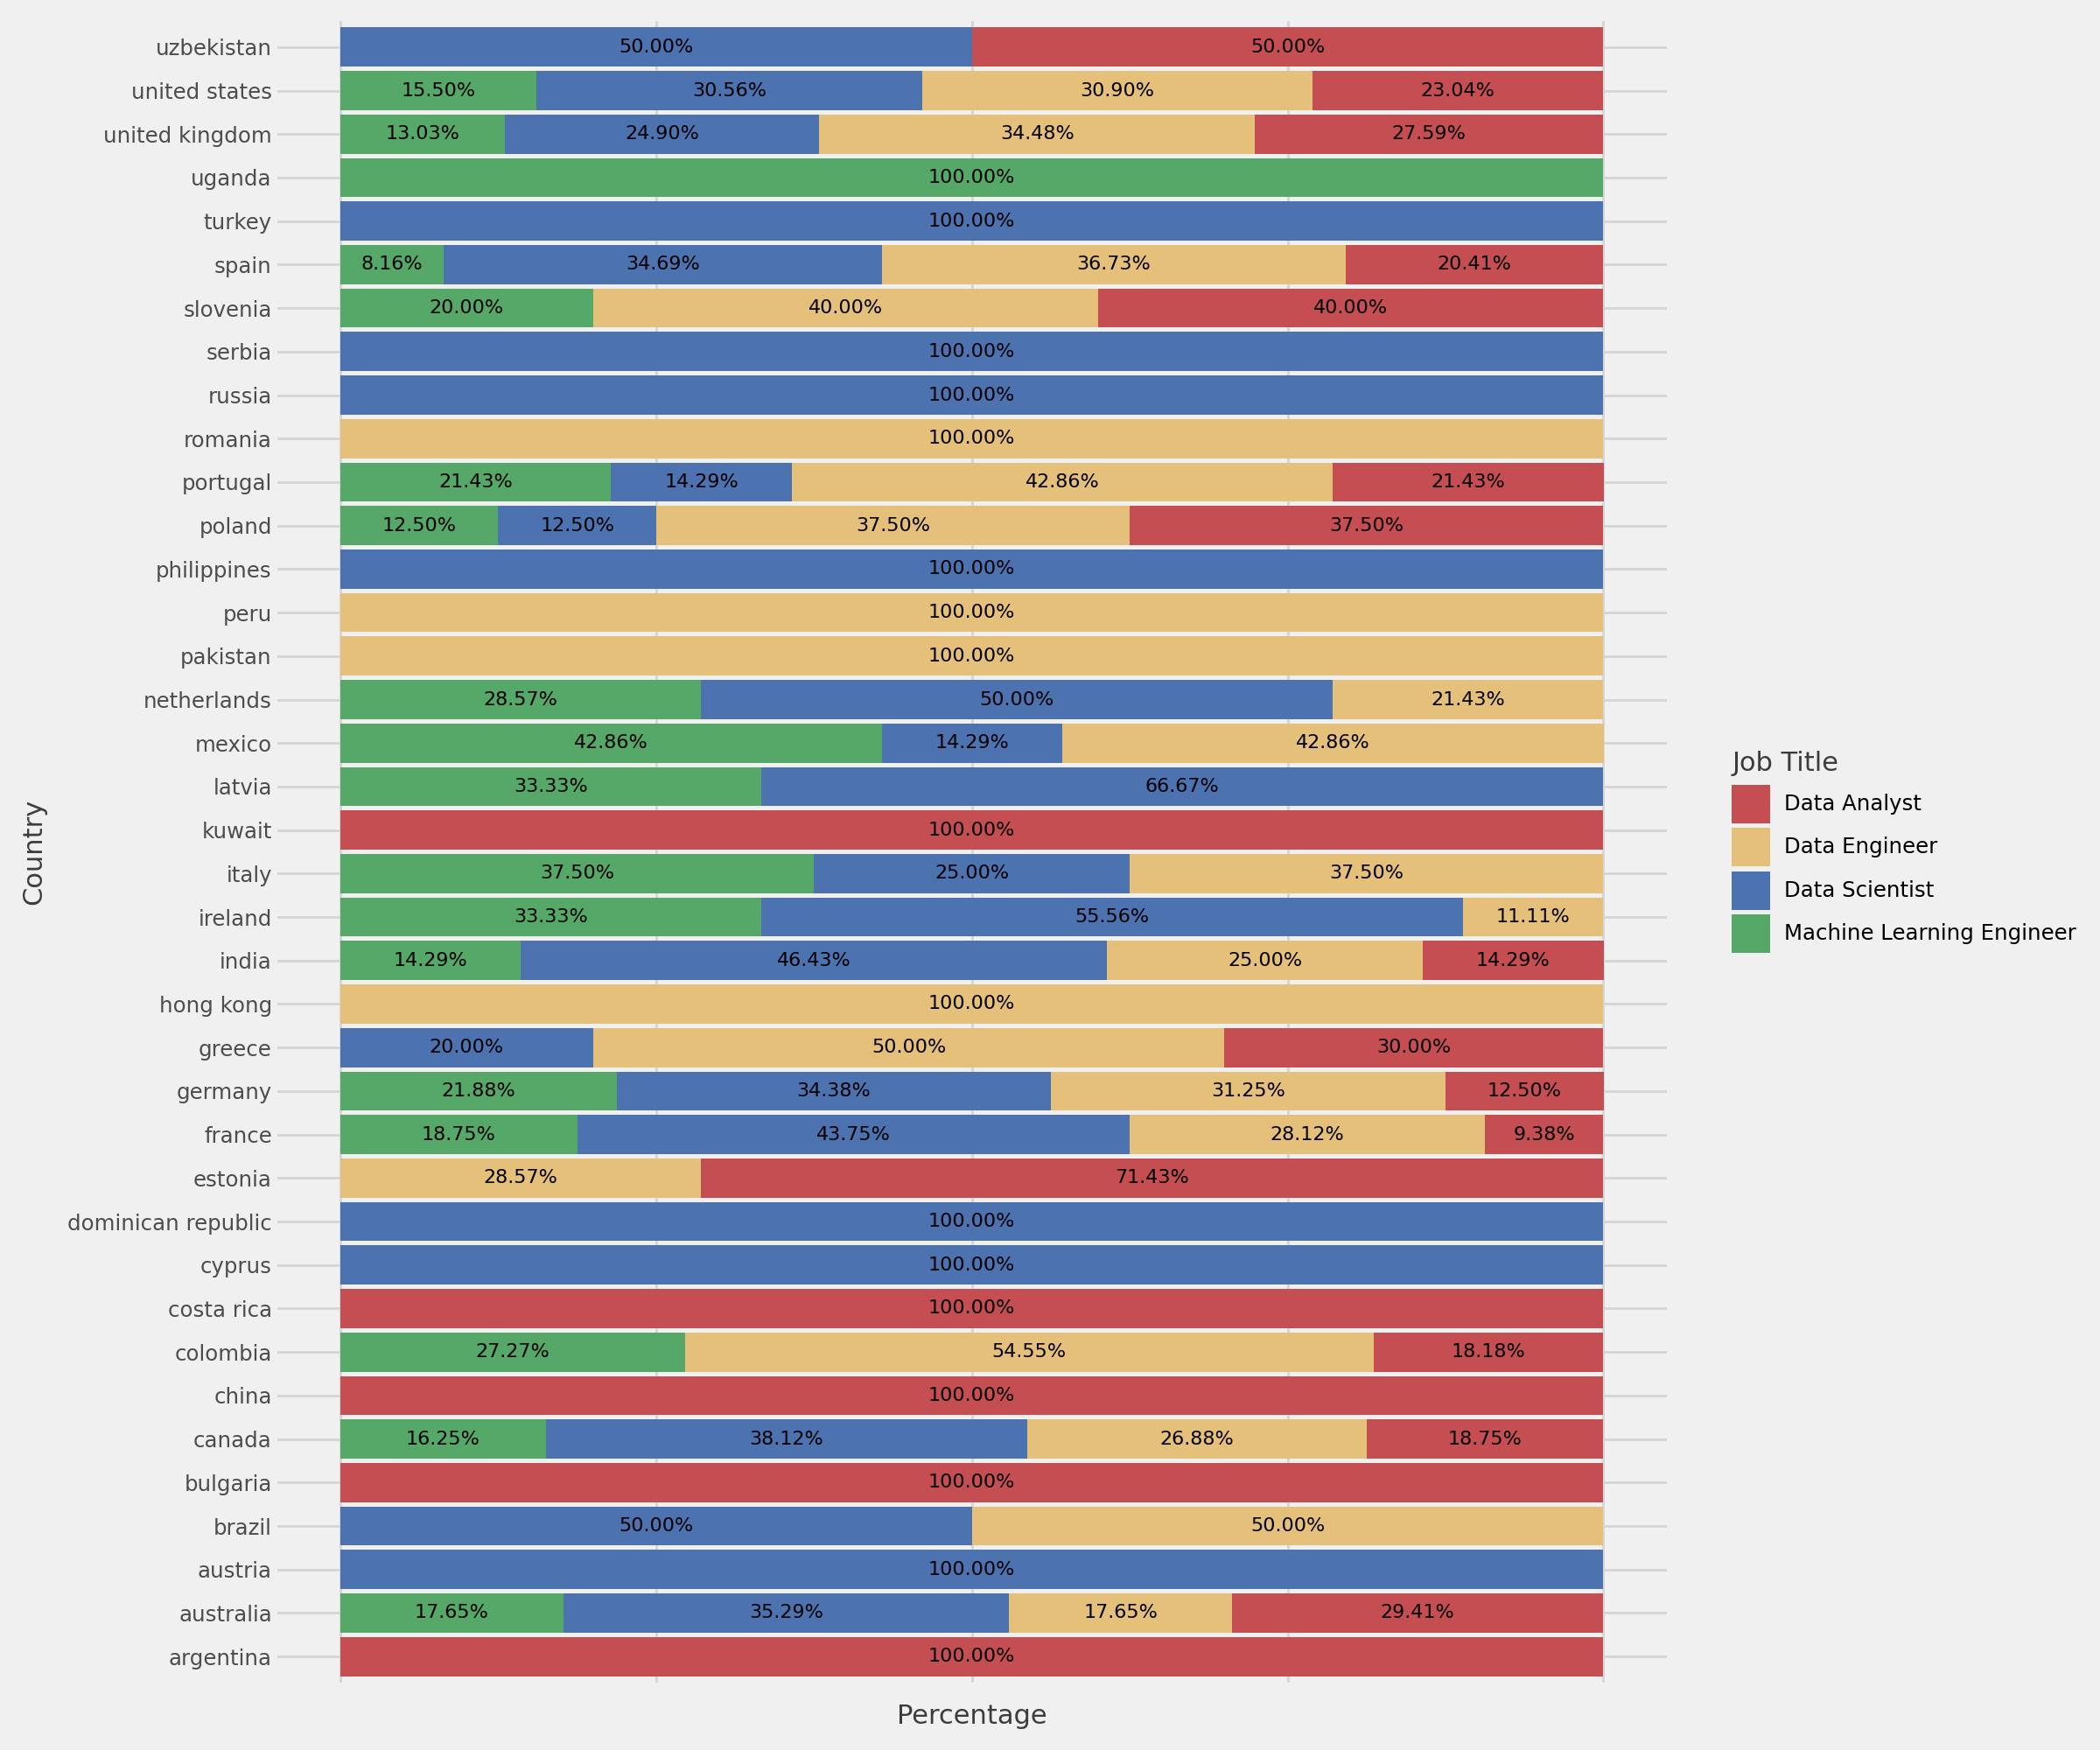

In [26]:
(
    ggplot(job_title_prop,aes(x="employee_residence", y="percentage", fill = "job_title"))
    + geom_col()
    + geom_text(aes(label = "percentage"), format_string = "{:.2f}%",position=position_stack(vjust=0.5),size = 8) # Add text labels (percentages) over bars
    + scale_fill_manual(cols,labels= lambda l: [x.title() for x in l]) # Custom fill colors and remove legend
    + theme(figure_size=(12,10),axis_text_x=element_blank())
    + labs(y = "Percentage", x = "Country", fill = "Job Title") # Add x and y axis labels
    + coord_flip()
)

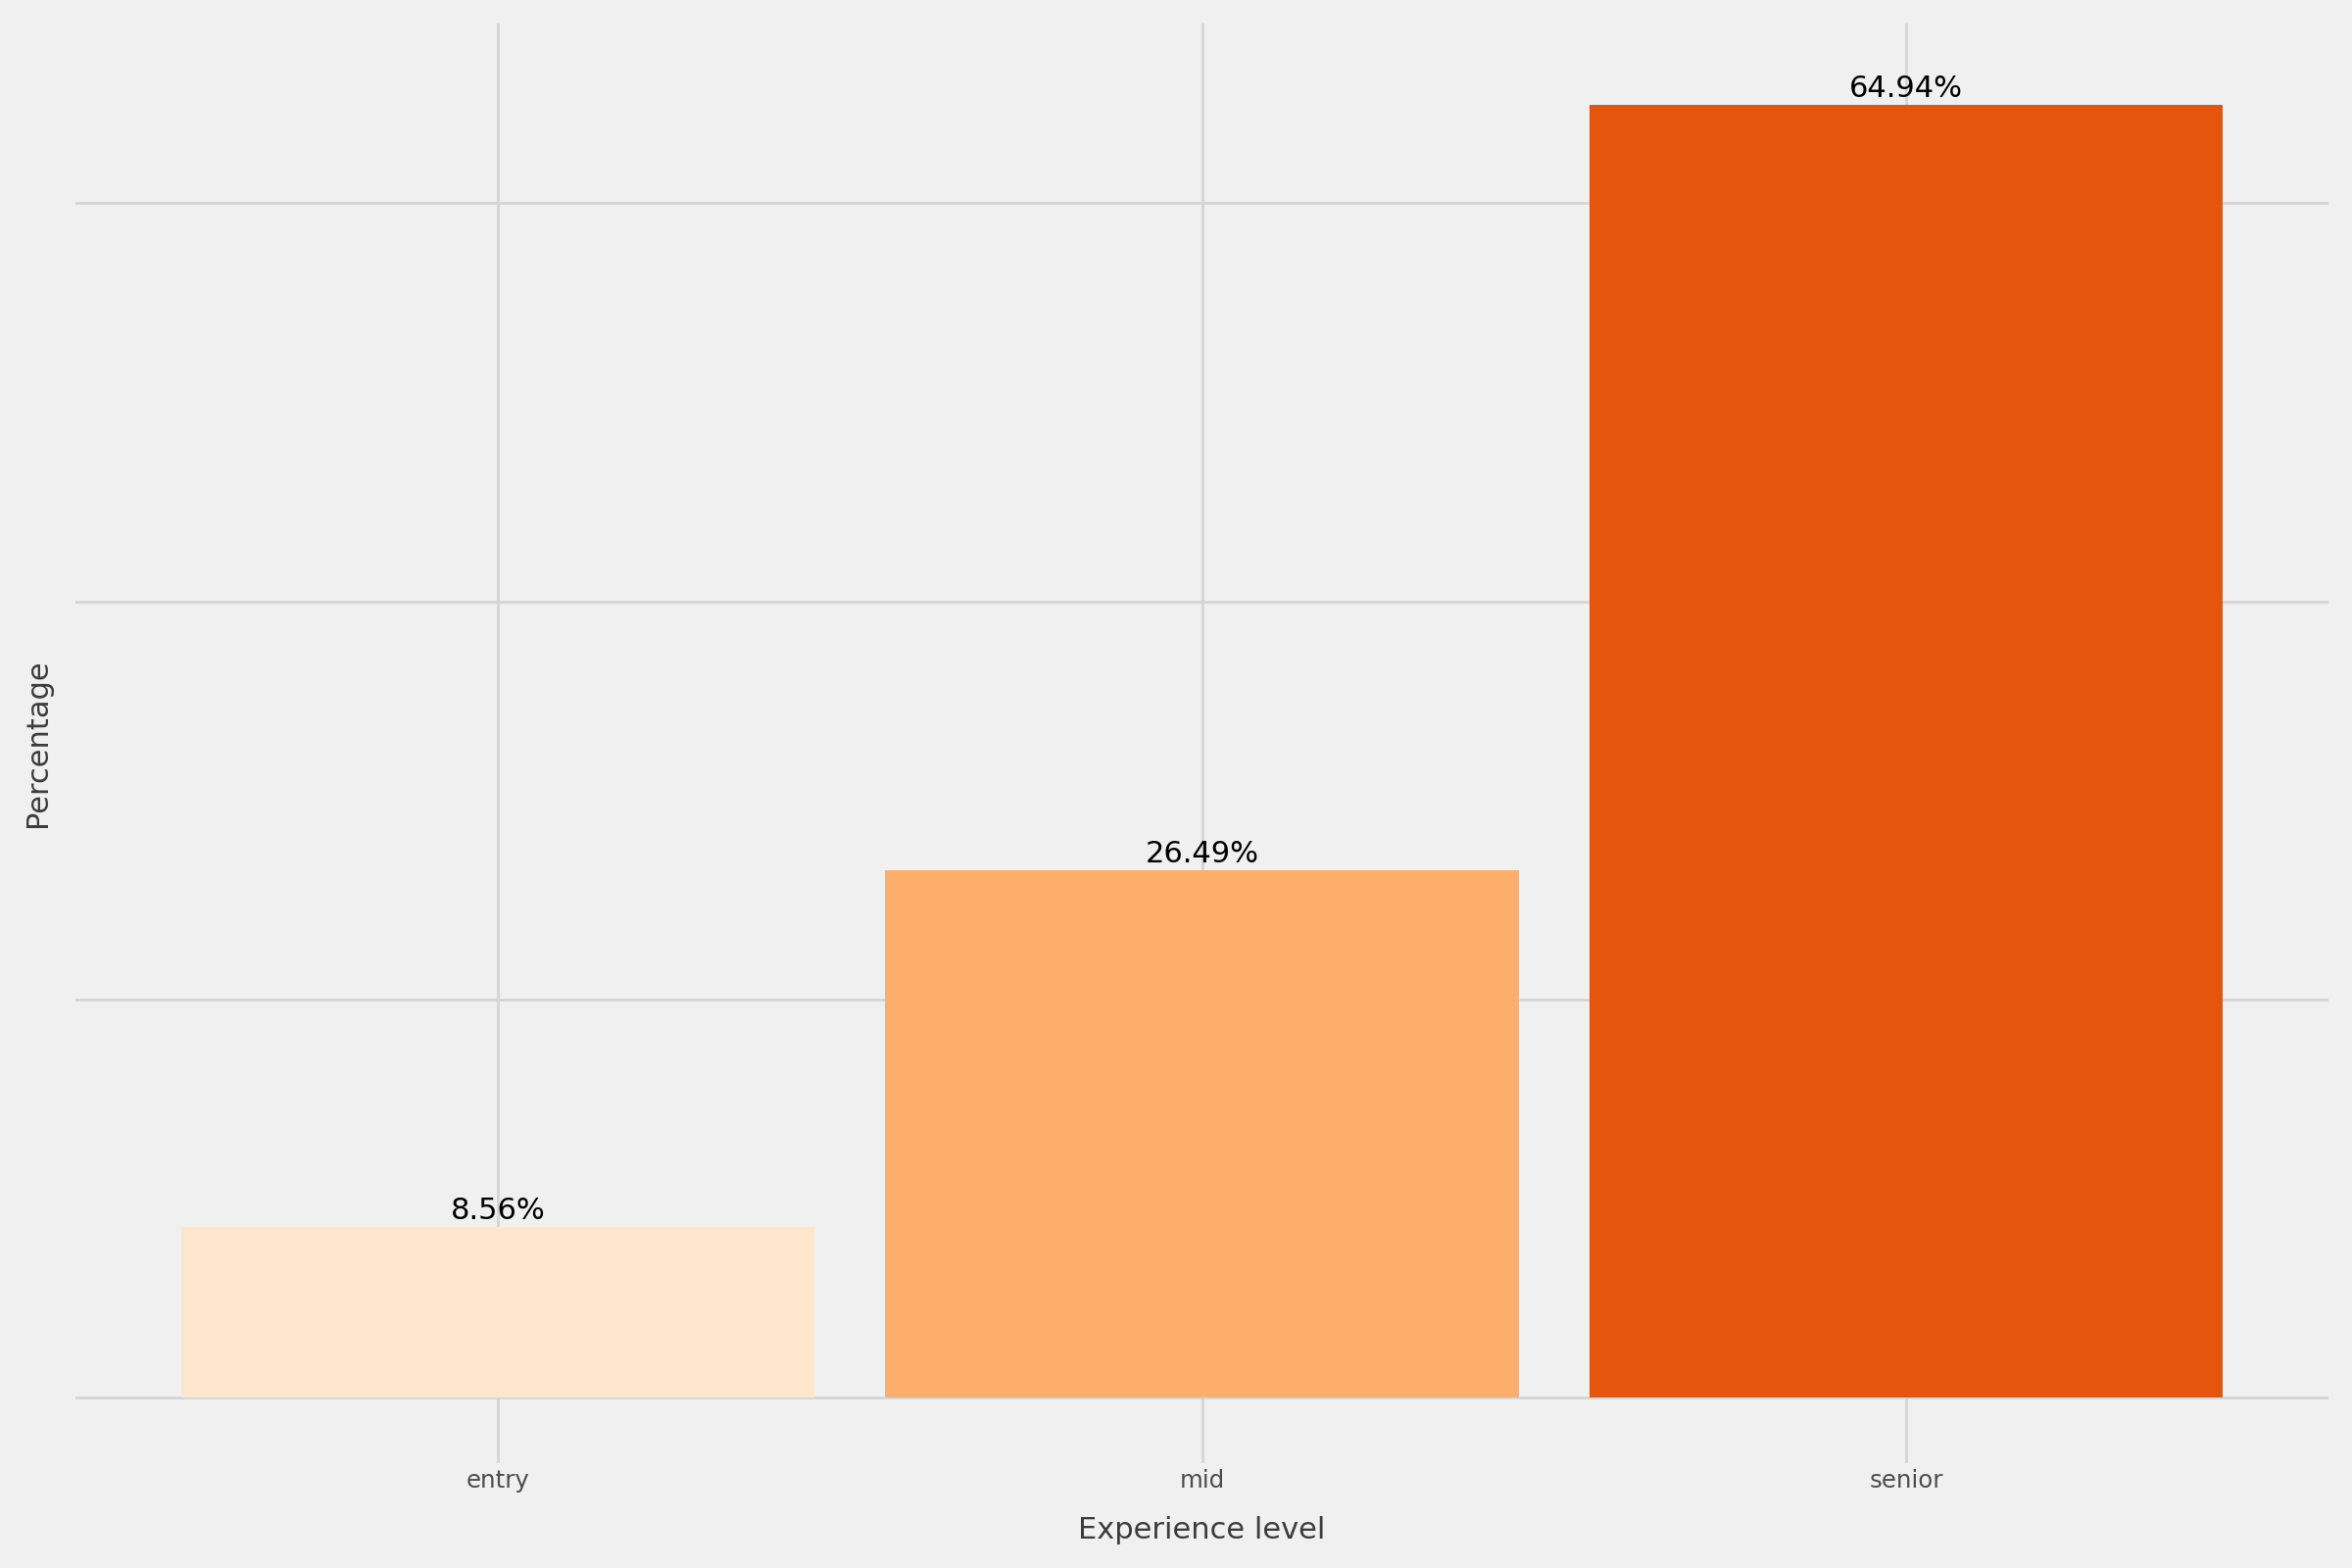

In [27]:
(
    ggplot(data, aes(x="experience_level",fill = "experience_level")) # Map experience_level to x-axis
    + geom_bar(aes(y = after_stat("count / sum(count) * 100"))) # Create bar chart and computing percentage
    + geom_text(aes(y = after_stat("prop * 100"), label = after_stat("prop * 100"),group = 1), stat = "count", format_string = "{:.2f}%", nudge_y = 0.8) # Add text labels (percentages) over bars
    + scale_fill_brewer(palette="Oranges",guide = None) # Custom fill colors and remove legend
    + labs(y="Percentage", x = "Experience level") # Add x and y axis labels
    + theme(axis_ticks_x=element_blank(),axis_ticks_y=element_blank(),axis_text_y=element_blank(), figure_size=(12,8)) # Remove y and x axis text and ticks and increase figure size
)

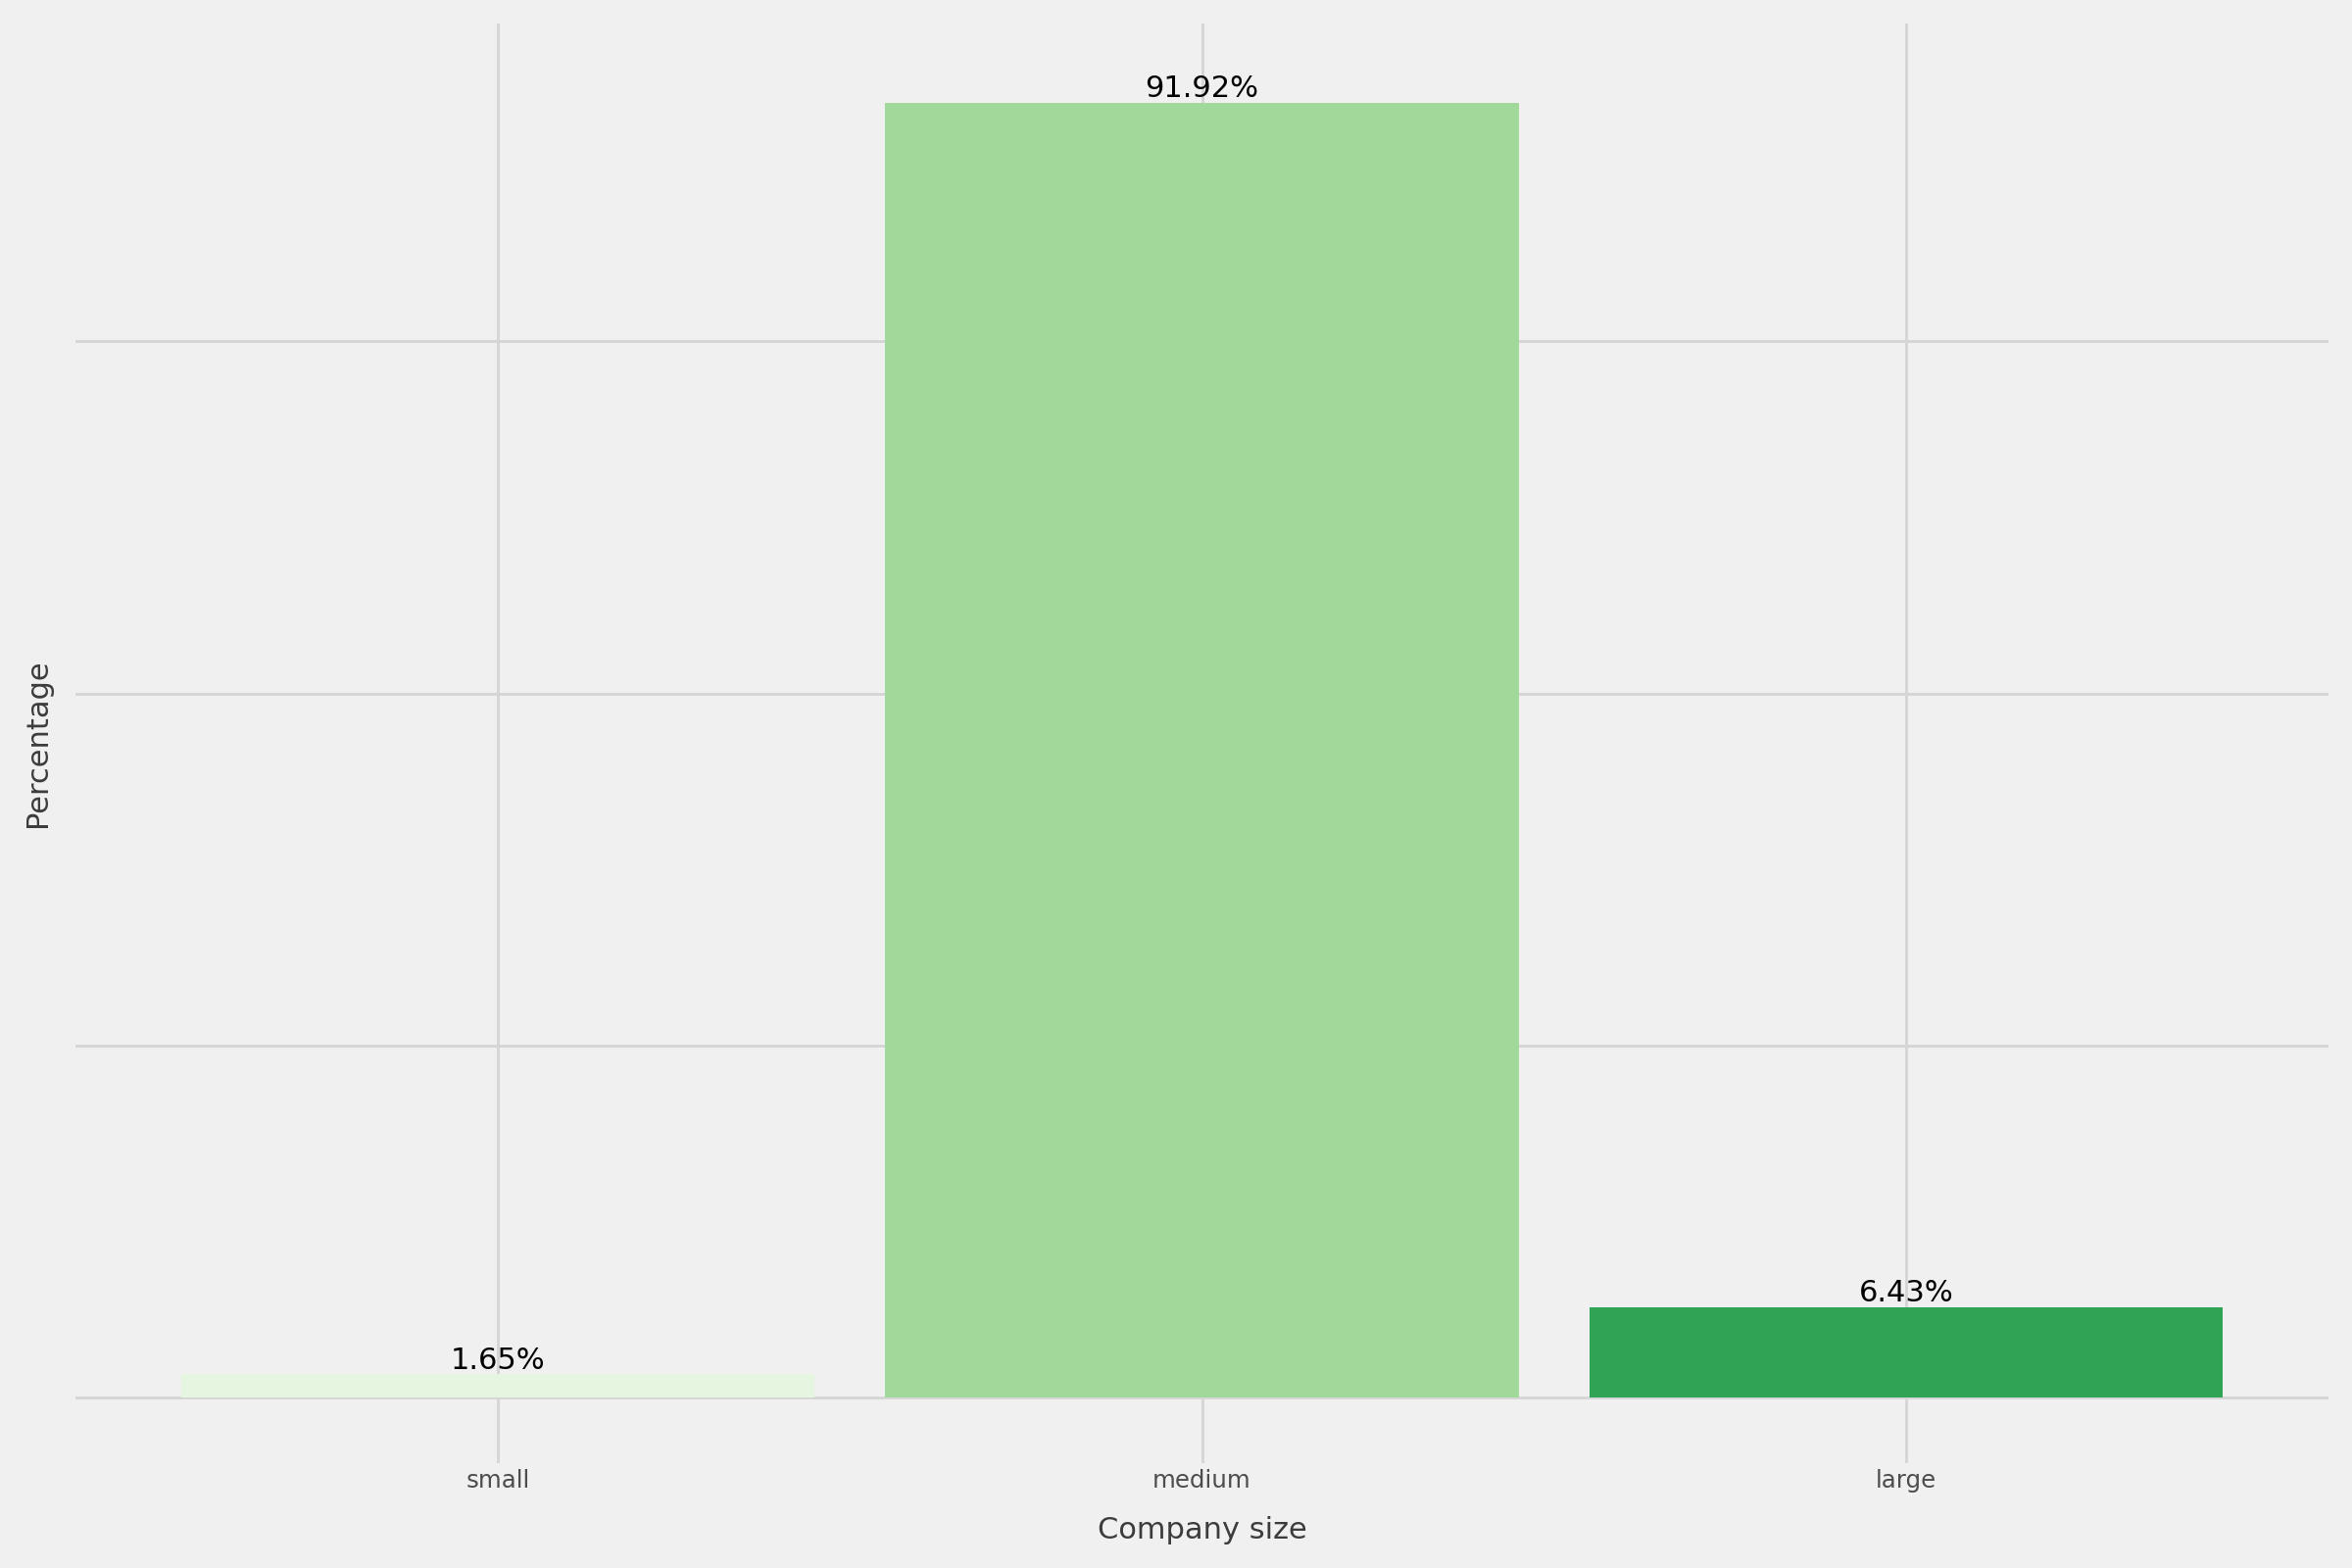

In [28]:
(
    ggplot(data, aes(x = "company_size", fill = "company_size")) # Map company_size to x-axis and passing argument fill
    + geom_bar(aes(y = after_stat("count / sum(count) *100")), stat = "count") # Create bar chart and computing percentage
    + geom_text(aes(y = after_stat("prop * 100"), label = after_stat("prop * 100"),group = 1), stat = "count", format_string = "{:.2f}%", nudge_y = 1) # Add text labels (percentages) over bars
    + scale_fill_brewer(palette = "Greens",guide = None) # Custom fill colors (greens from colorbrewer2) and remove legend
    + theme(axis_ticks_y=element_blank(),axis_text_y=element_blank(), figure_size=(12,8)) # Remove y-axis text and ticks and increase figure size
    + labs(y="Percentage", x = "Company size") # Add x and y axis labels
)

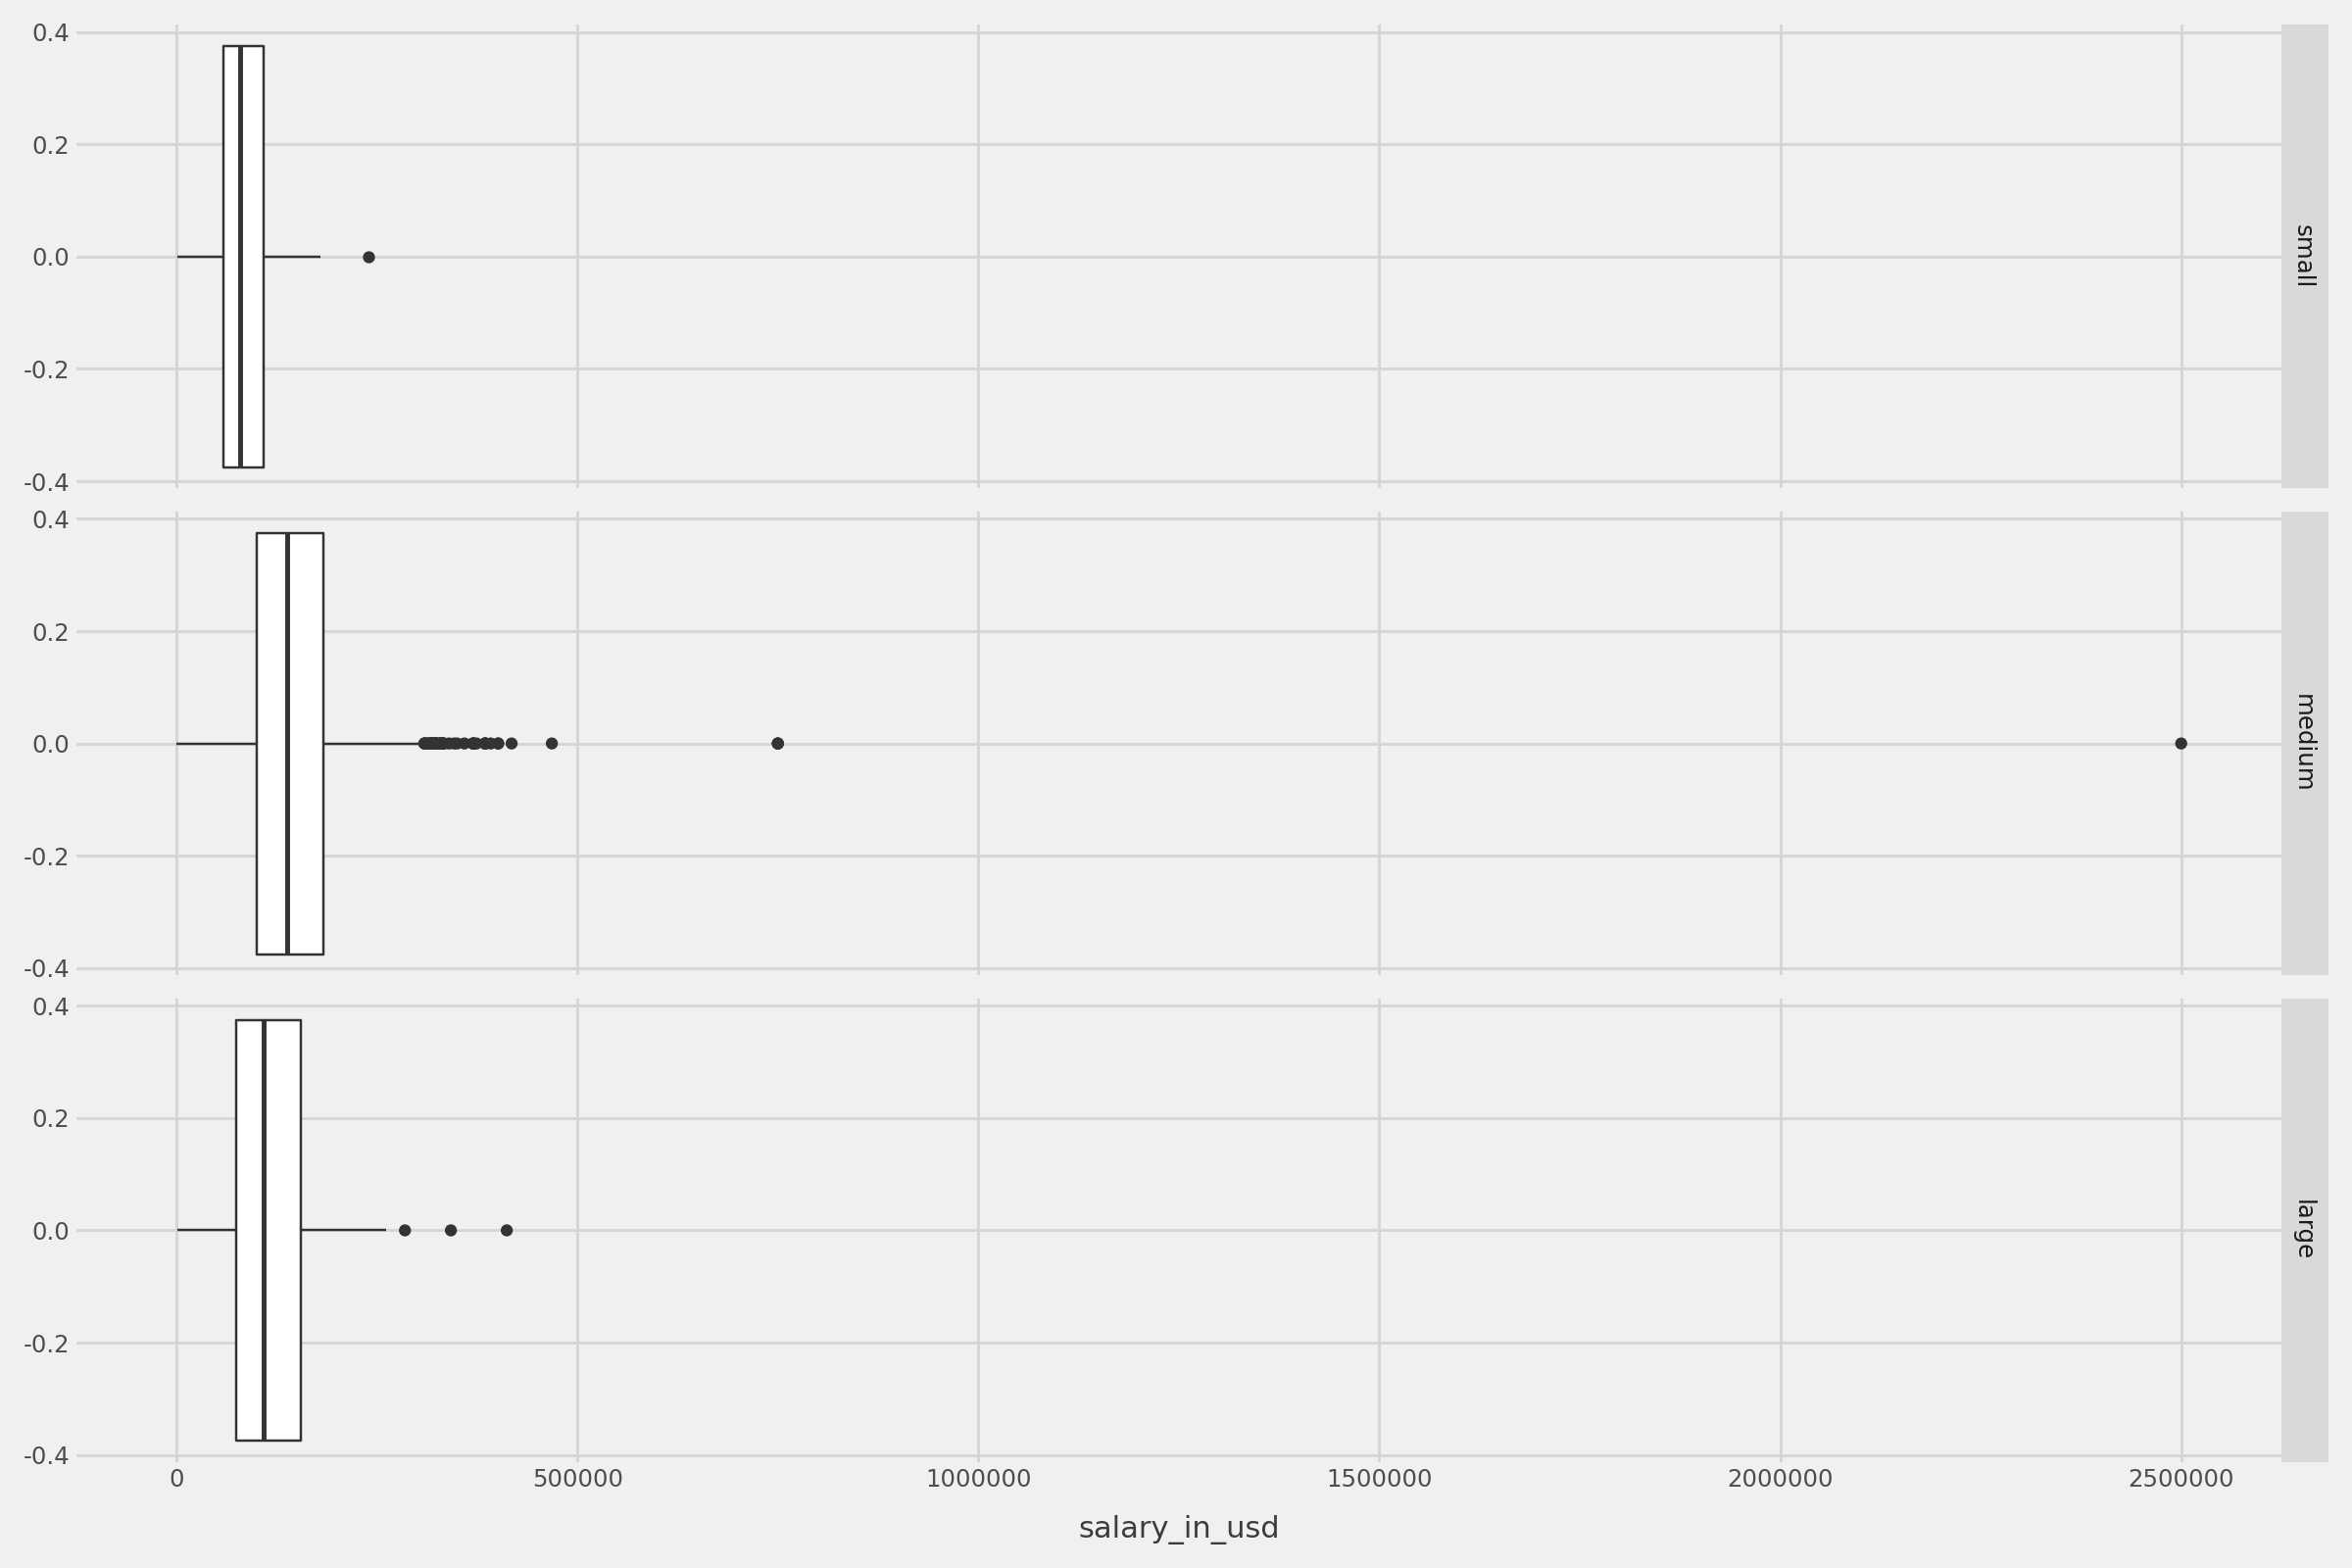

In [29]:
(
    ggplot(data  ,aes(y = "salary_in_usd"))
    + geom_boxplot()
    + facet_grid(rows="company_size")
    + coord_flip()
    + theme(figure_size=(12,8))
)

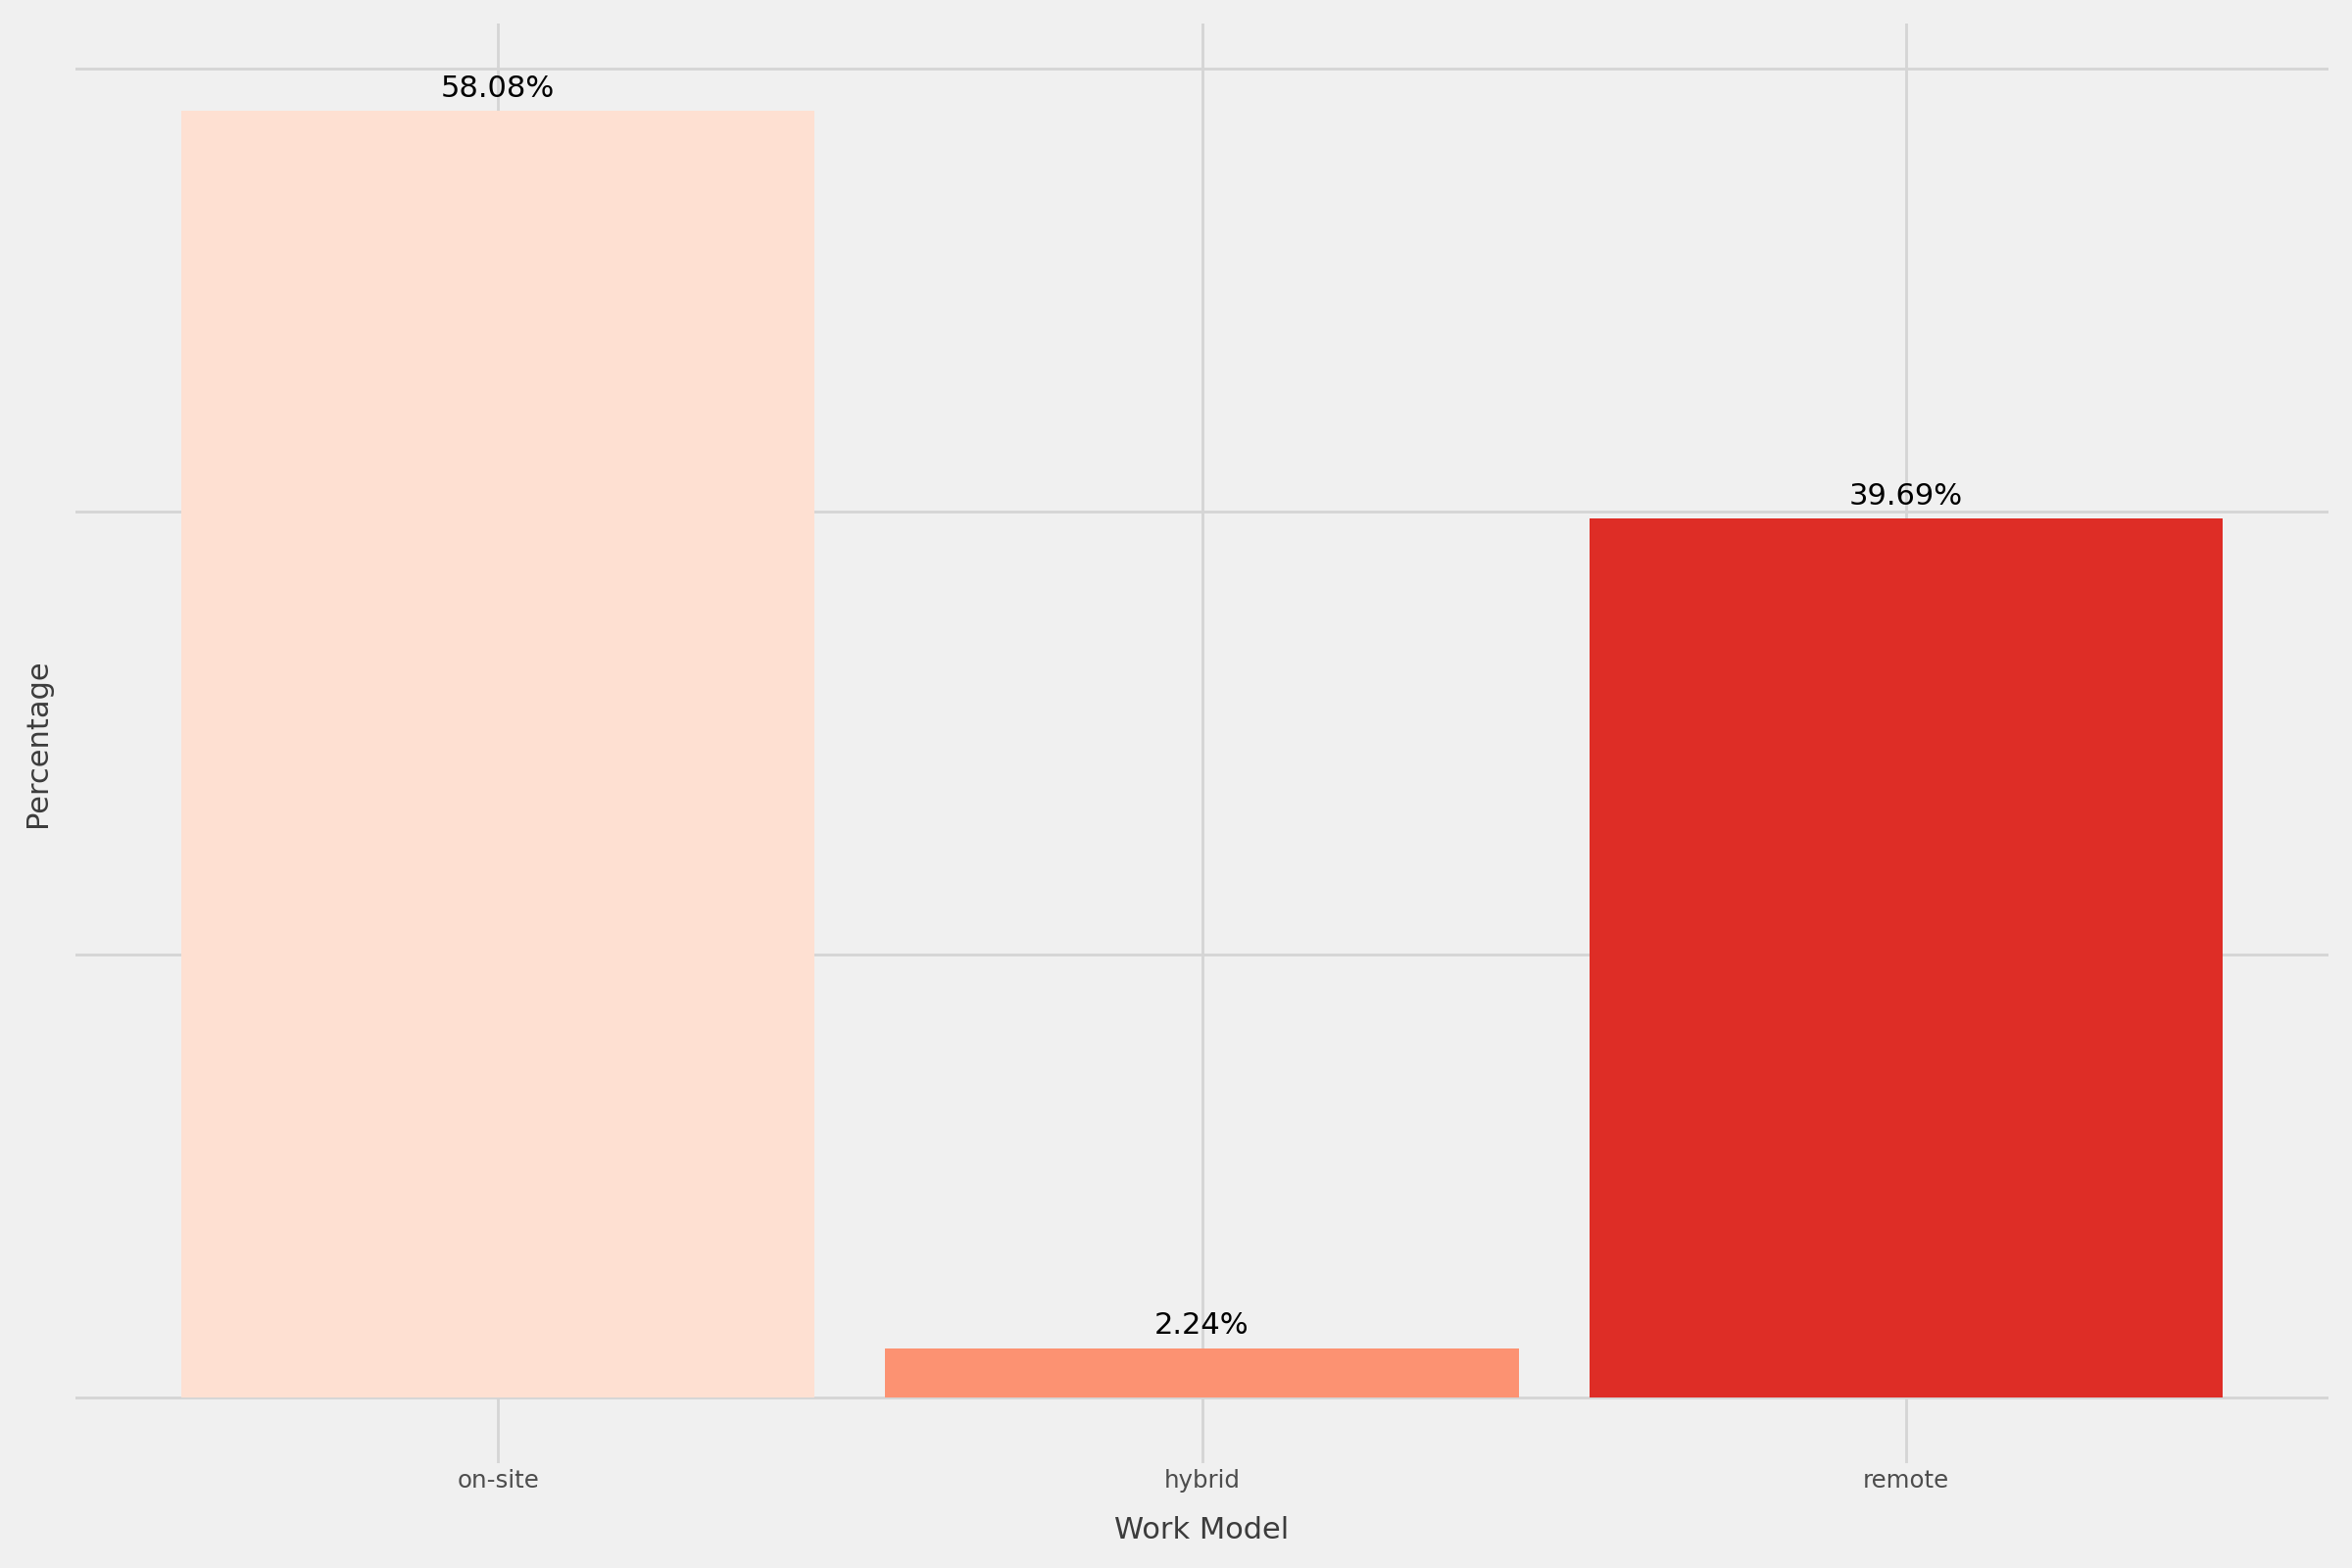

In [30]:
(
    ggplot(data, aes(x = "work_models", fill = "work_models")) # Map work_models to x-axis and pass argument fill
    + geom_bar(aes(y = after_stat("count / sum(count) * 100"))) # Create bar chart and compute percentage
    + geom_text(aes(y = after_stat("prop*100"), label = after_stat("prop *100"), group = 1), stat = "count", format_string = "{:.2f}%", nudge_y = 1) # Compute and add text labels (percentages) over bars 
    + scale_fill_brewer(palette="Reds",guide = None) # Custom fill colors (reds from colorbrewer2) and remove legend
    + labs(x = "Work Model", y = "Percentage") # Add x and y axis labels
    + theme(figure_size=(12,8), axis_ticks_y=element_blank(), axis_text_y=element_blank()) # Remove y-axis text and ticks and increase figure size
)

In [31]:
remote_prop_job_title = data.groupby(["company_size","job_title"])["work_models"].value_counts(normalize=True).reset_index(name="percentage")
remote_prop_job_title["percentage"] = remote_prop_job_title["percentage"] * 100

2025-09-02 17:52:58 [warning  ] The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning. category=FutureWarning filename=C:\Users\Marco\AppData\Local\Temp\ipykernel_16708\3357666172.py lineno=1


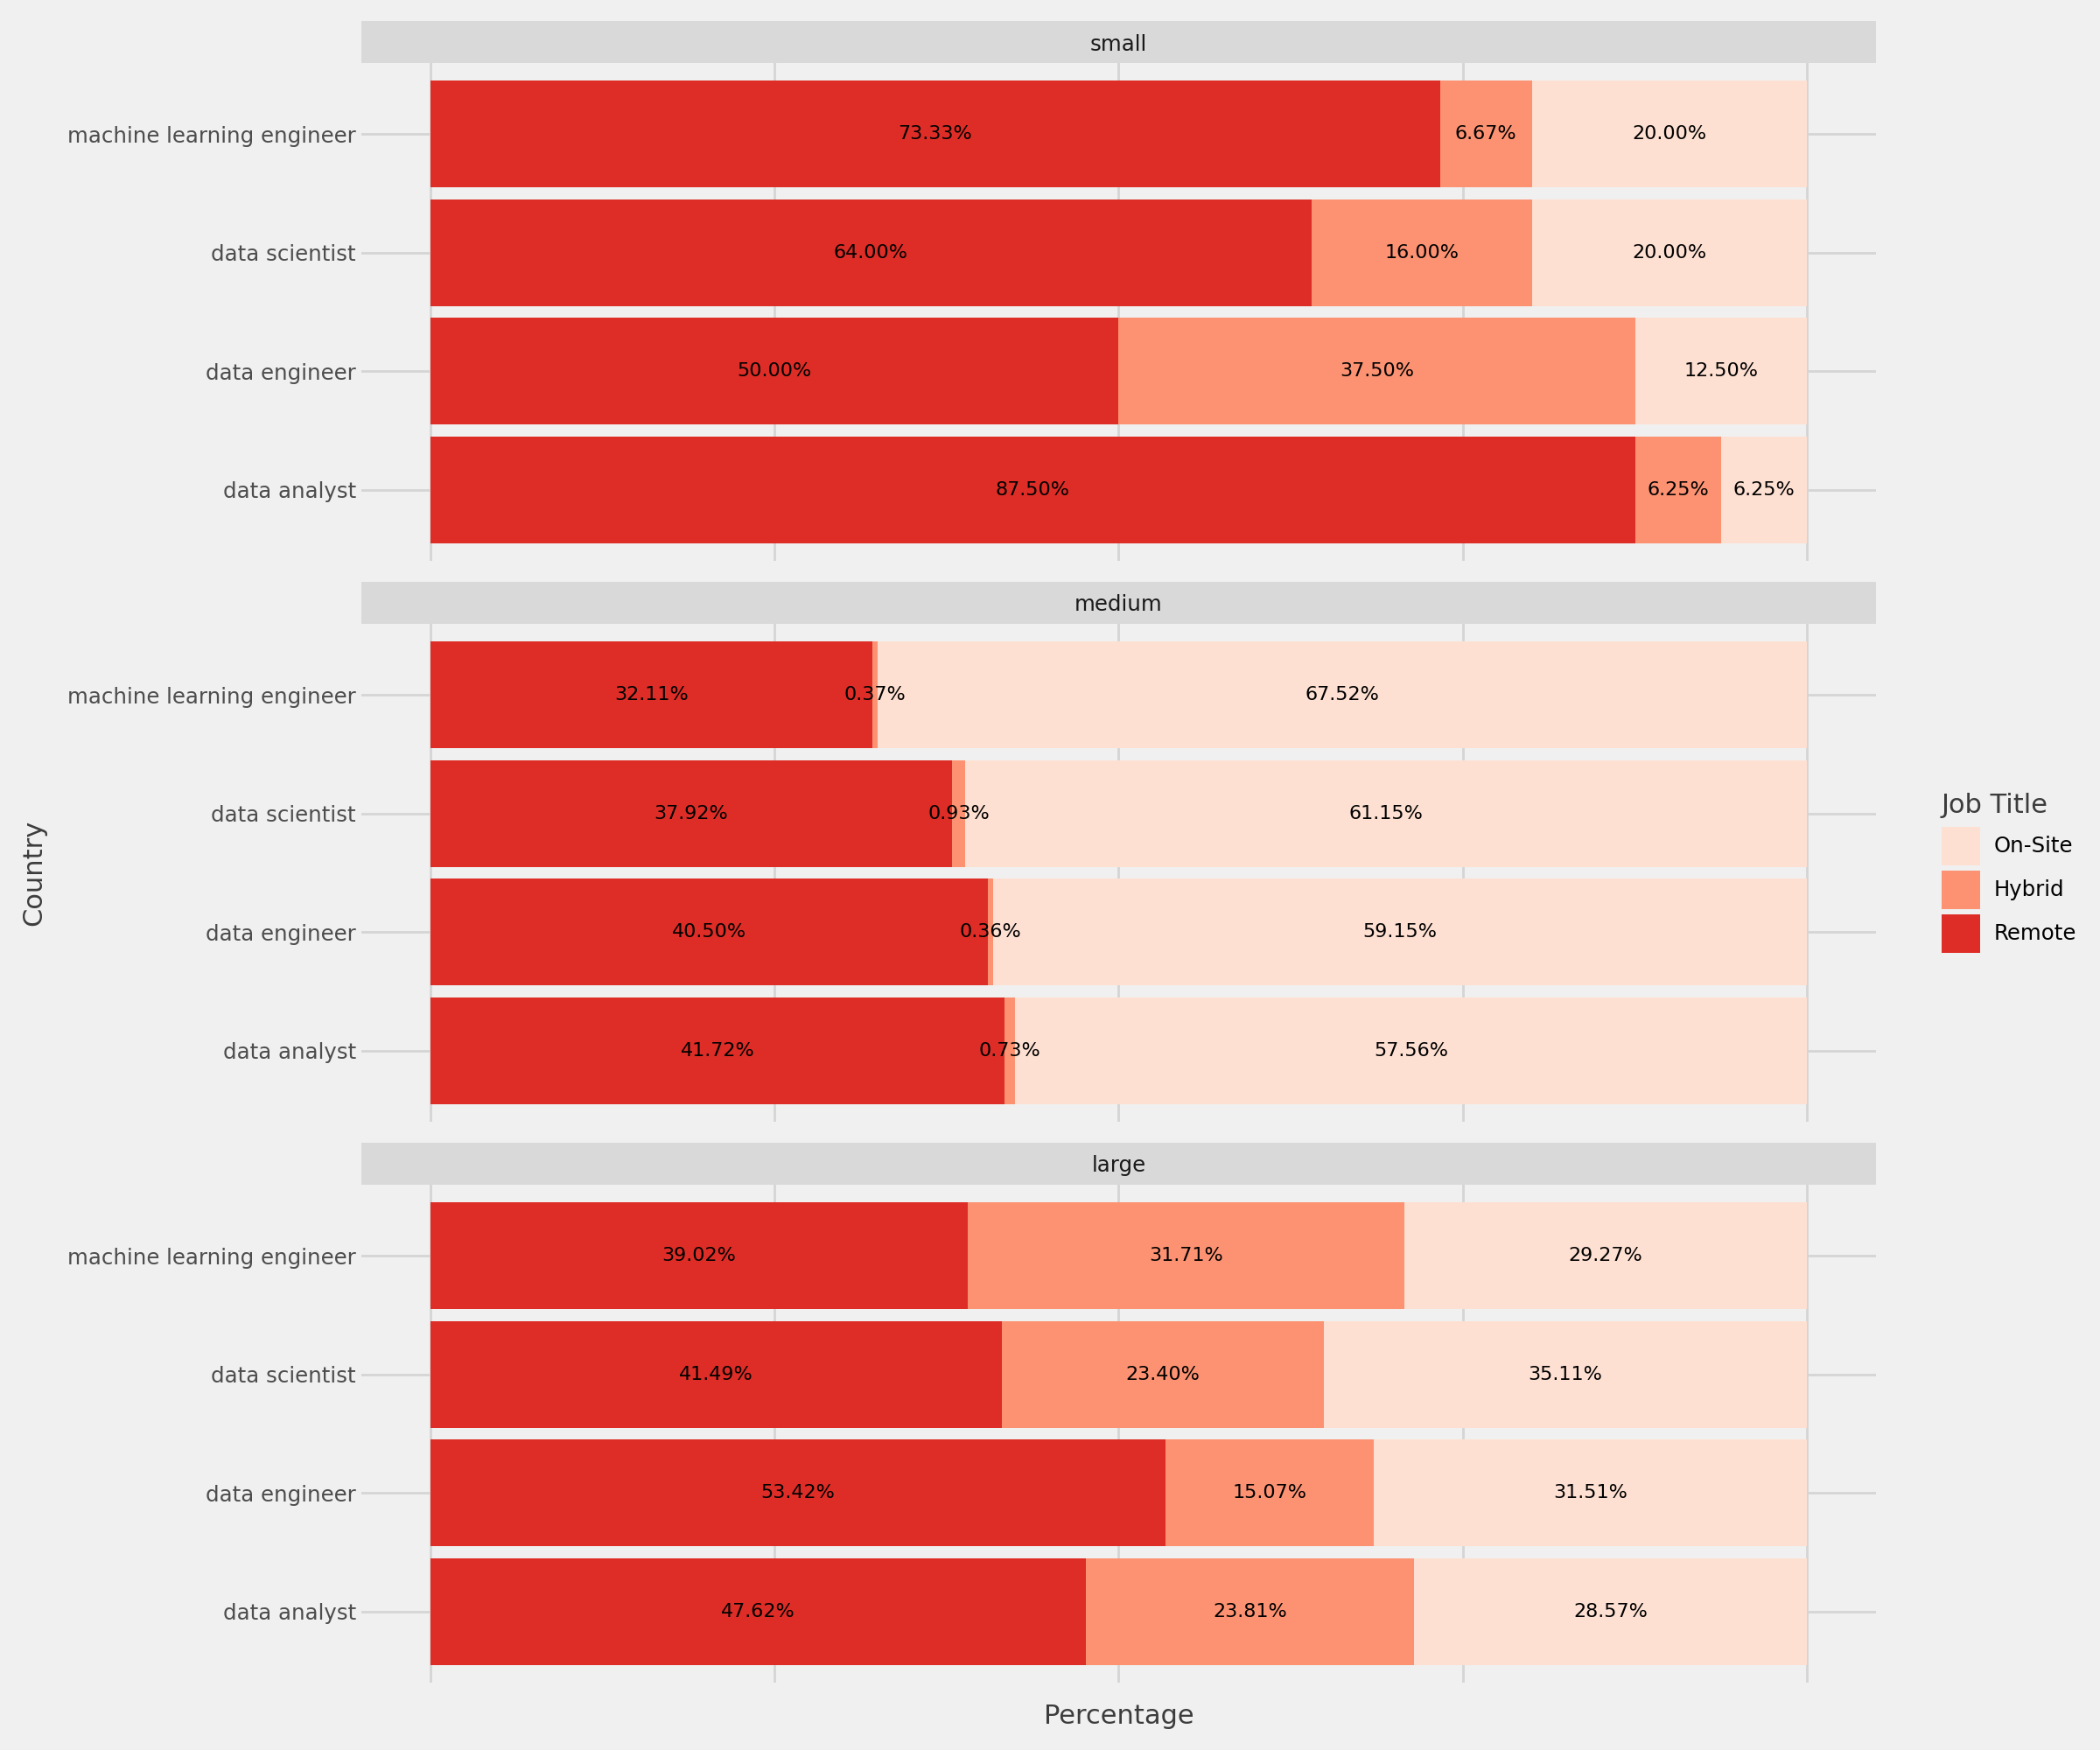

In [32]:
(
    ggplot(remote_prop_job_title,aes(x="job_title", y="percentage", fill = "work_models"))
    + geom_col()
    + geom_text(aes(label = "percentage"), format_string = "{:.2f}%",position=position_stack(vjust=0.5),size = 8) # Add text labels (percentages) over bars
    + scale_fill_brewer(palette = "Reds",labels= lambda l: [x.title() for x in l]) # Custom fill colors and remove legend
    + theme(figure_size=(12,10),axis_text_x=element_blank())
    + labs(y = "Percentage", x = "Country", fill = "Job Title") # Add x and y axis labels
    + coord_flip()
    + facet_wrap("company_size", ncol=1)
)

In [33]:
data

,index,job_title,experience_level,employment_type,work_models,work_year,employee_residence,salary,salary_in_usd,company_size,country,ppp_conversion_factor_for_private_consumption
0,0,data engineer,mid,full-time,remote,2024,united states,148100,148100.000000,medium,United States of America,1.000000
1,1,data engineer,mid,full-time,remote,2024,united states,98700,98700.000000,medium,United States of America,1.000000
2,2,data scientist,senior,full-time,remote,2024,united states,140032,140032.000000,medium,United States of America,1.000000
3,3,data scientist,senior,full-time,remote,2024,united states,100022,100022.000000,medium,United States of America,1.000000
4,12,data scientist,mid,full-time,remote,2024,united states,148100,148100.000000,medium,United States of America,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
3883,6587,data scientist,entry,full-time,on-site,2020,germany,43200,58778.868997,small,Germany,0.734958
3884,6588,data engineer,entry,full-time,remote,2020,pakistan,48000,65309.854441,large,Germany,0.734958
3885,6589,data engineer,mid,full-time,remote,2020,germany,51999,70750.981689,small,Germany,0.734958
3886,6591,data scientist,mid,full-time,on-site,2020,germany,70000,95243.537726,large,Germany,0.734958


In [34]:
salary_median = data.groupby("country", as_index = False)["salary_in_usd"].median().reset_index() # Compute median salary by country
salary_median = merge(salary_median, gdf.loc[:,["ADMIN","geometry"]], left_on ="country", right_on = "ADMIN",how = "right").drop_duplicates()

In [35]:
salary_median

,index,country,salary_in_usd,ADMIN,geometry
0,NaN,NaN,NaN,Fiji,"MULTIPOLYGON (((180 -16.06713, 180 -16.55522, ..."
1,NaN,NaN,NaN,United Republic of Tanzania,"POLYGON ((33.90371 -0.95, 34.07262 -1.05982, 3..."
2,NaN,NaN,NaN,Western Sahara,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,2.0,Canada,114795.834995,Canada,"MULTIPOLYGON (((-122.84 49, -122.97421 49.0025..."
4,19.0,United States of America,144000.000000,United States of America,"MULTIPOLYGON (((-122.84 49, -120 49, -117.0312..."
...,...,...,...,...,...
172,NaN,NaN,NaN,Republic of Serbia,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
173,NaN,NaN,NaN,Montenegro,"POLYGON ((20.0707 42.58863, 19.80161 42.50009,..."
174,NaN,NaN,NaN,Kosovo,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
175,NaN,NaN,NaN,Trinidad and Tobago,"POLYGON ((-61.68 10.76, -61.105 10.89, -60.895..."


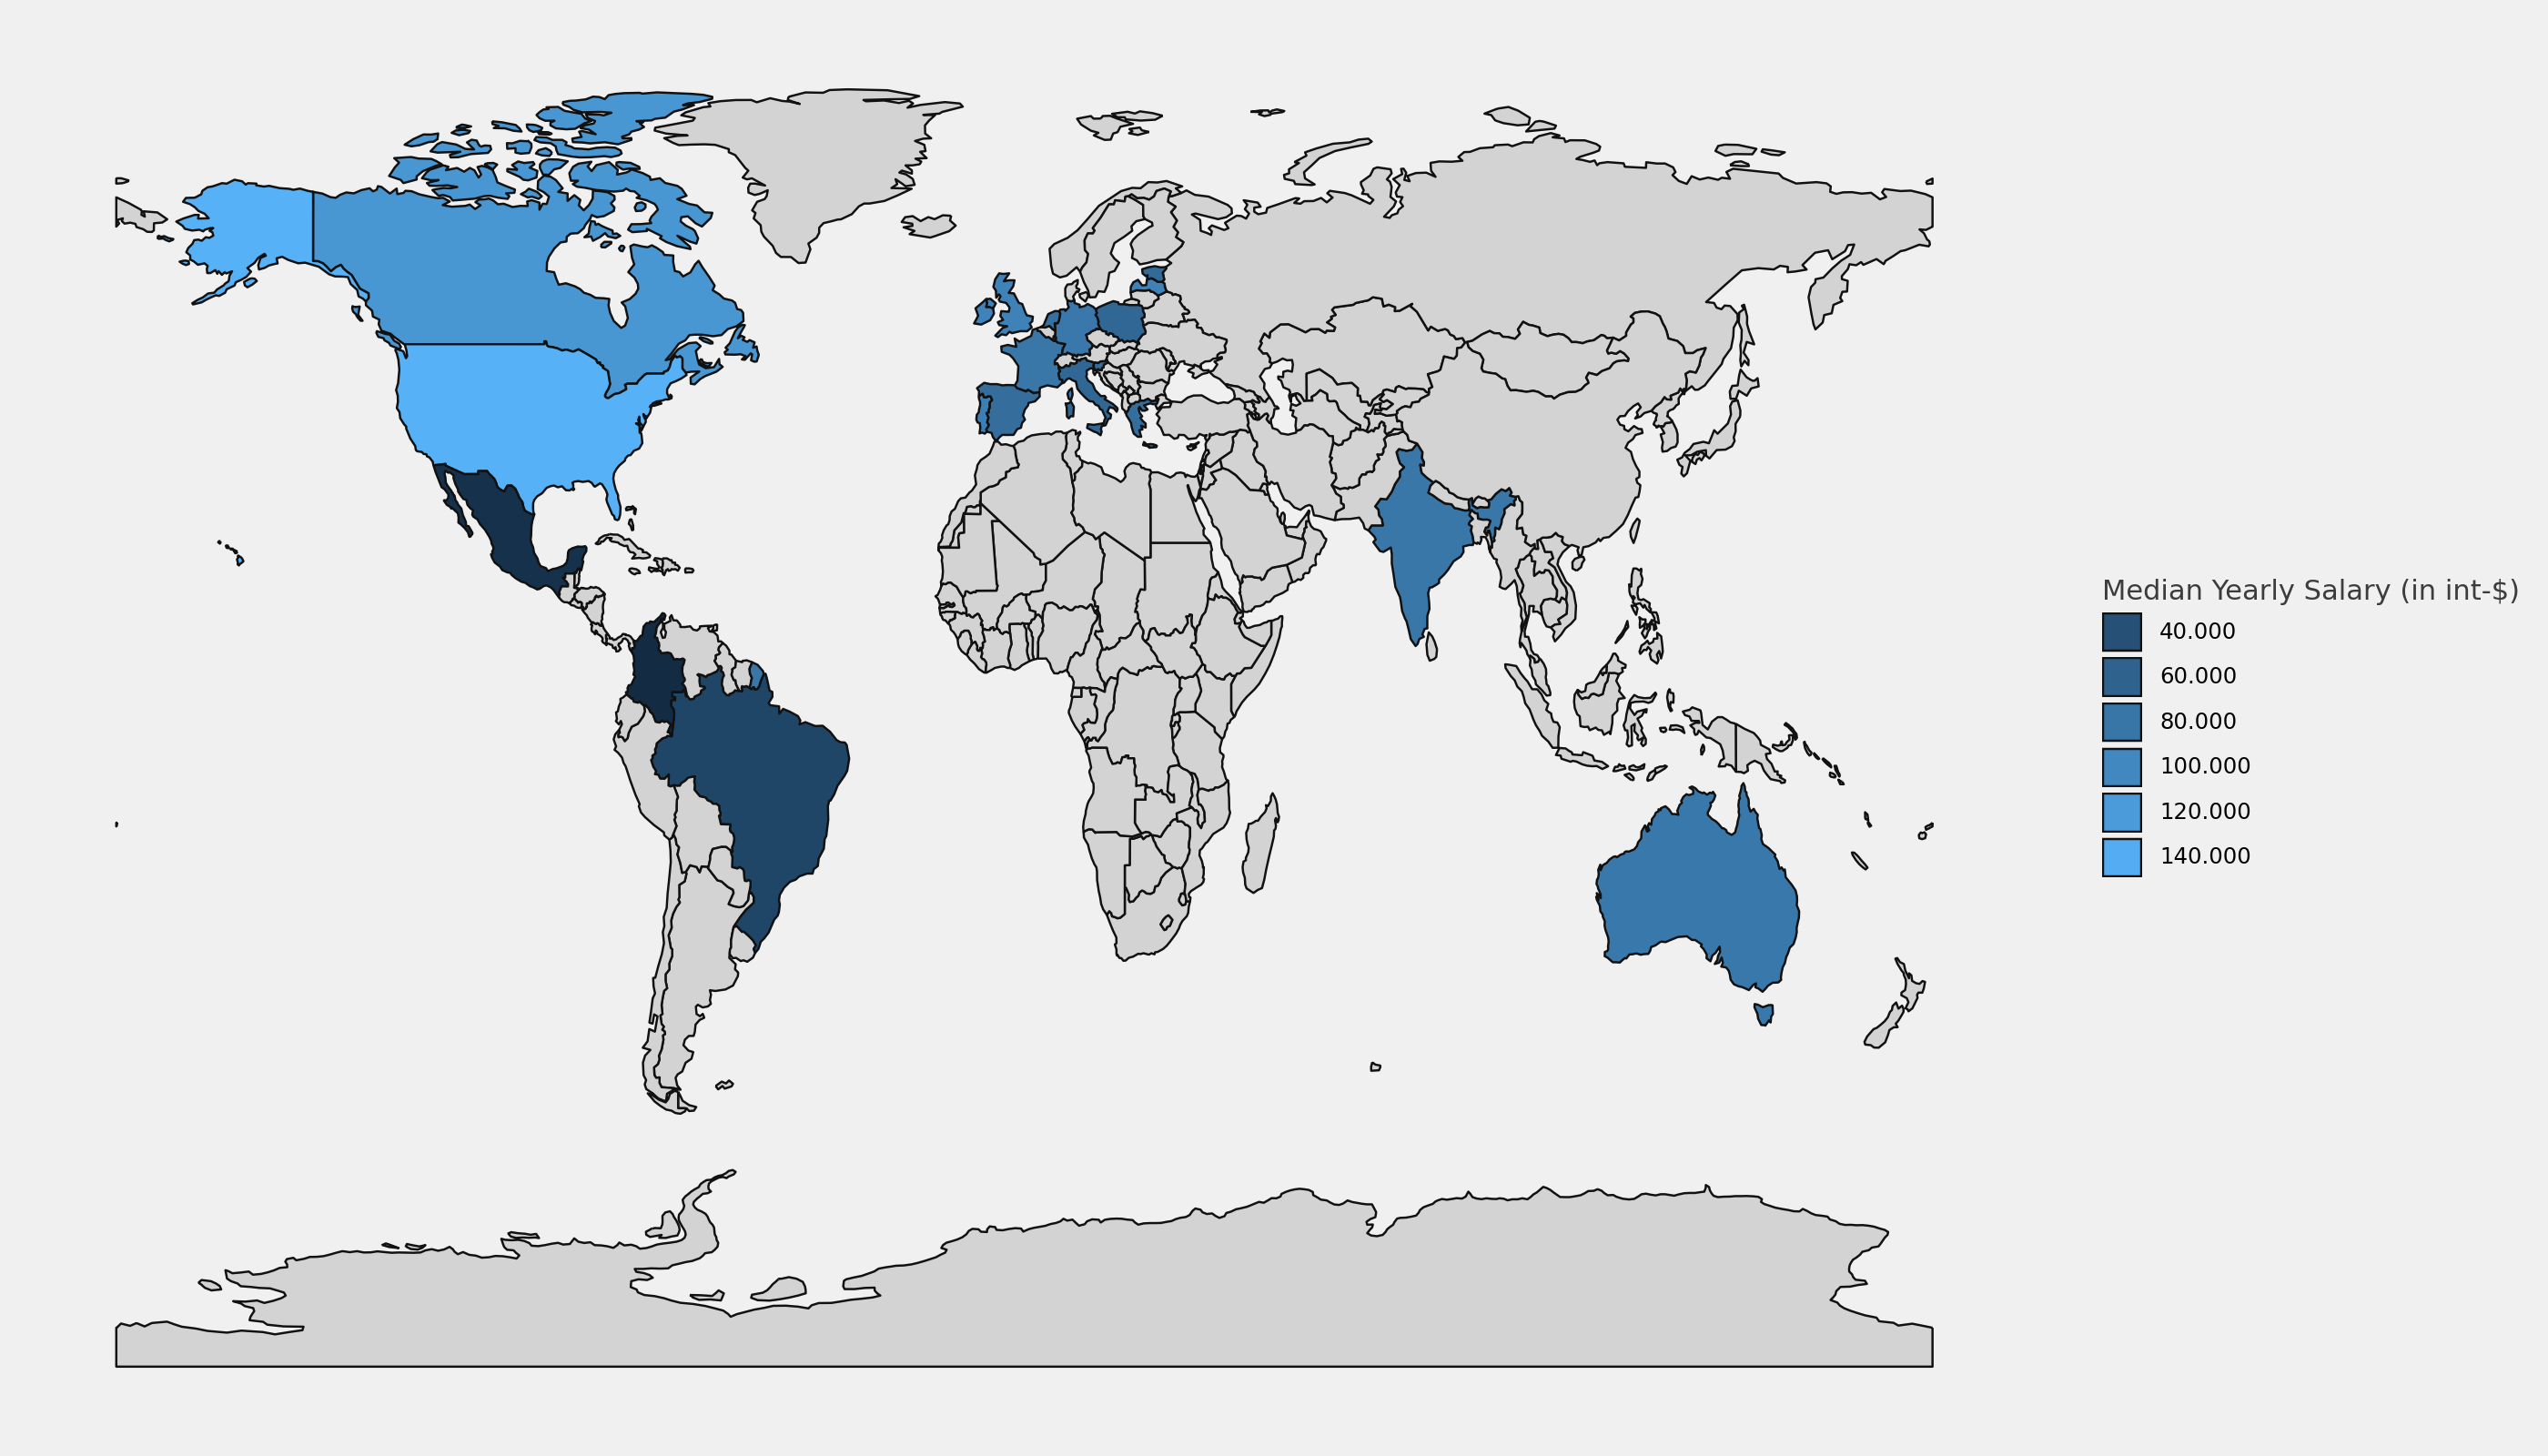

In [36]:
def labeller1(x):
    return("{:,.0f}".format(x).replace(",",".")) # Define labeller function

(
    ggplot(salary_median, aes(fill = "salary_in_usd")) # Pass fill aesthetic
    + geom_map() # Create map visualization
    + theme(figure_size=(14,8), axis_text_x=element_blank(), axis_text_y=element_blank(),panel_grid=element_blank()) # Customize figure size, and remove axis text and grid
    + scale_fill_gradient(name = "Median Yearly Salary (in int-$)", # Define fill gradient
                          guide = "legend", # Customize legend
                          na_value="lightgrey", # Define color for missing values
                          labels=lambda l: [labeller1(x) for x in l], # Format labels using labeller1 function
                          breaks = range(40000,160000,20000)) # Define breaks for color scale
)

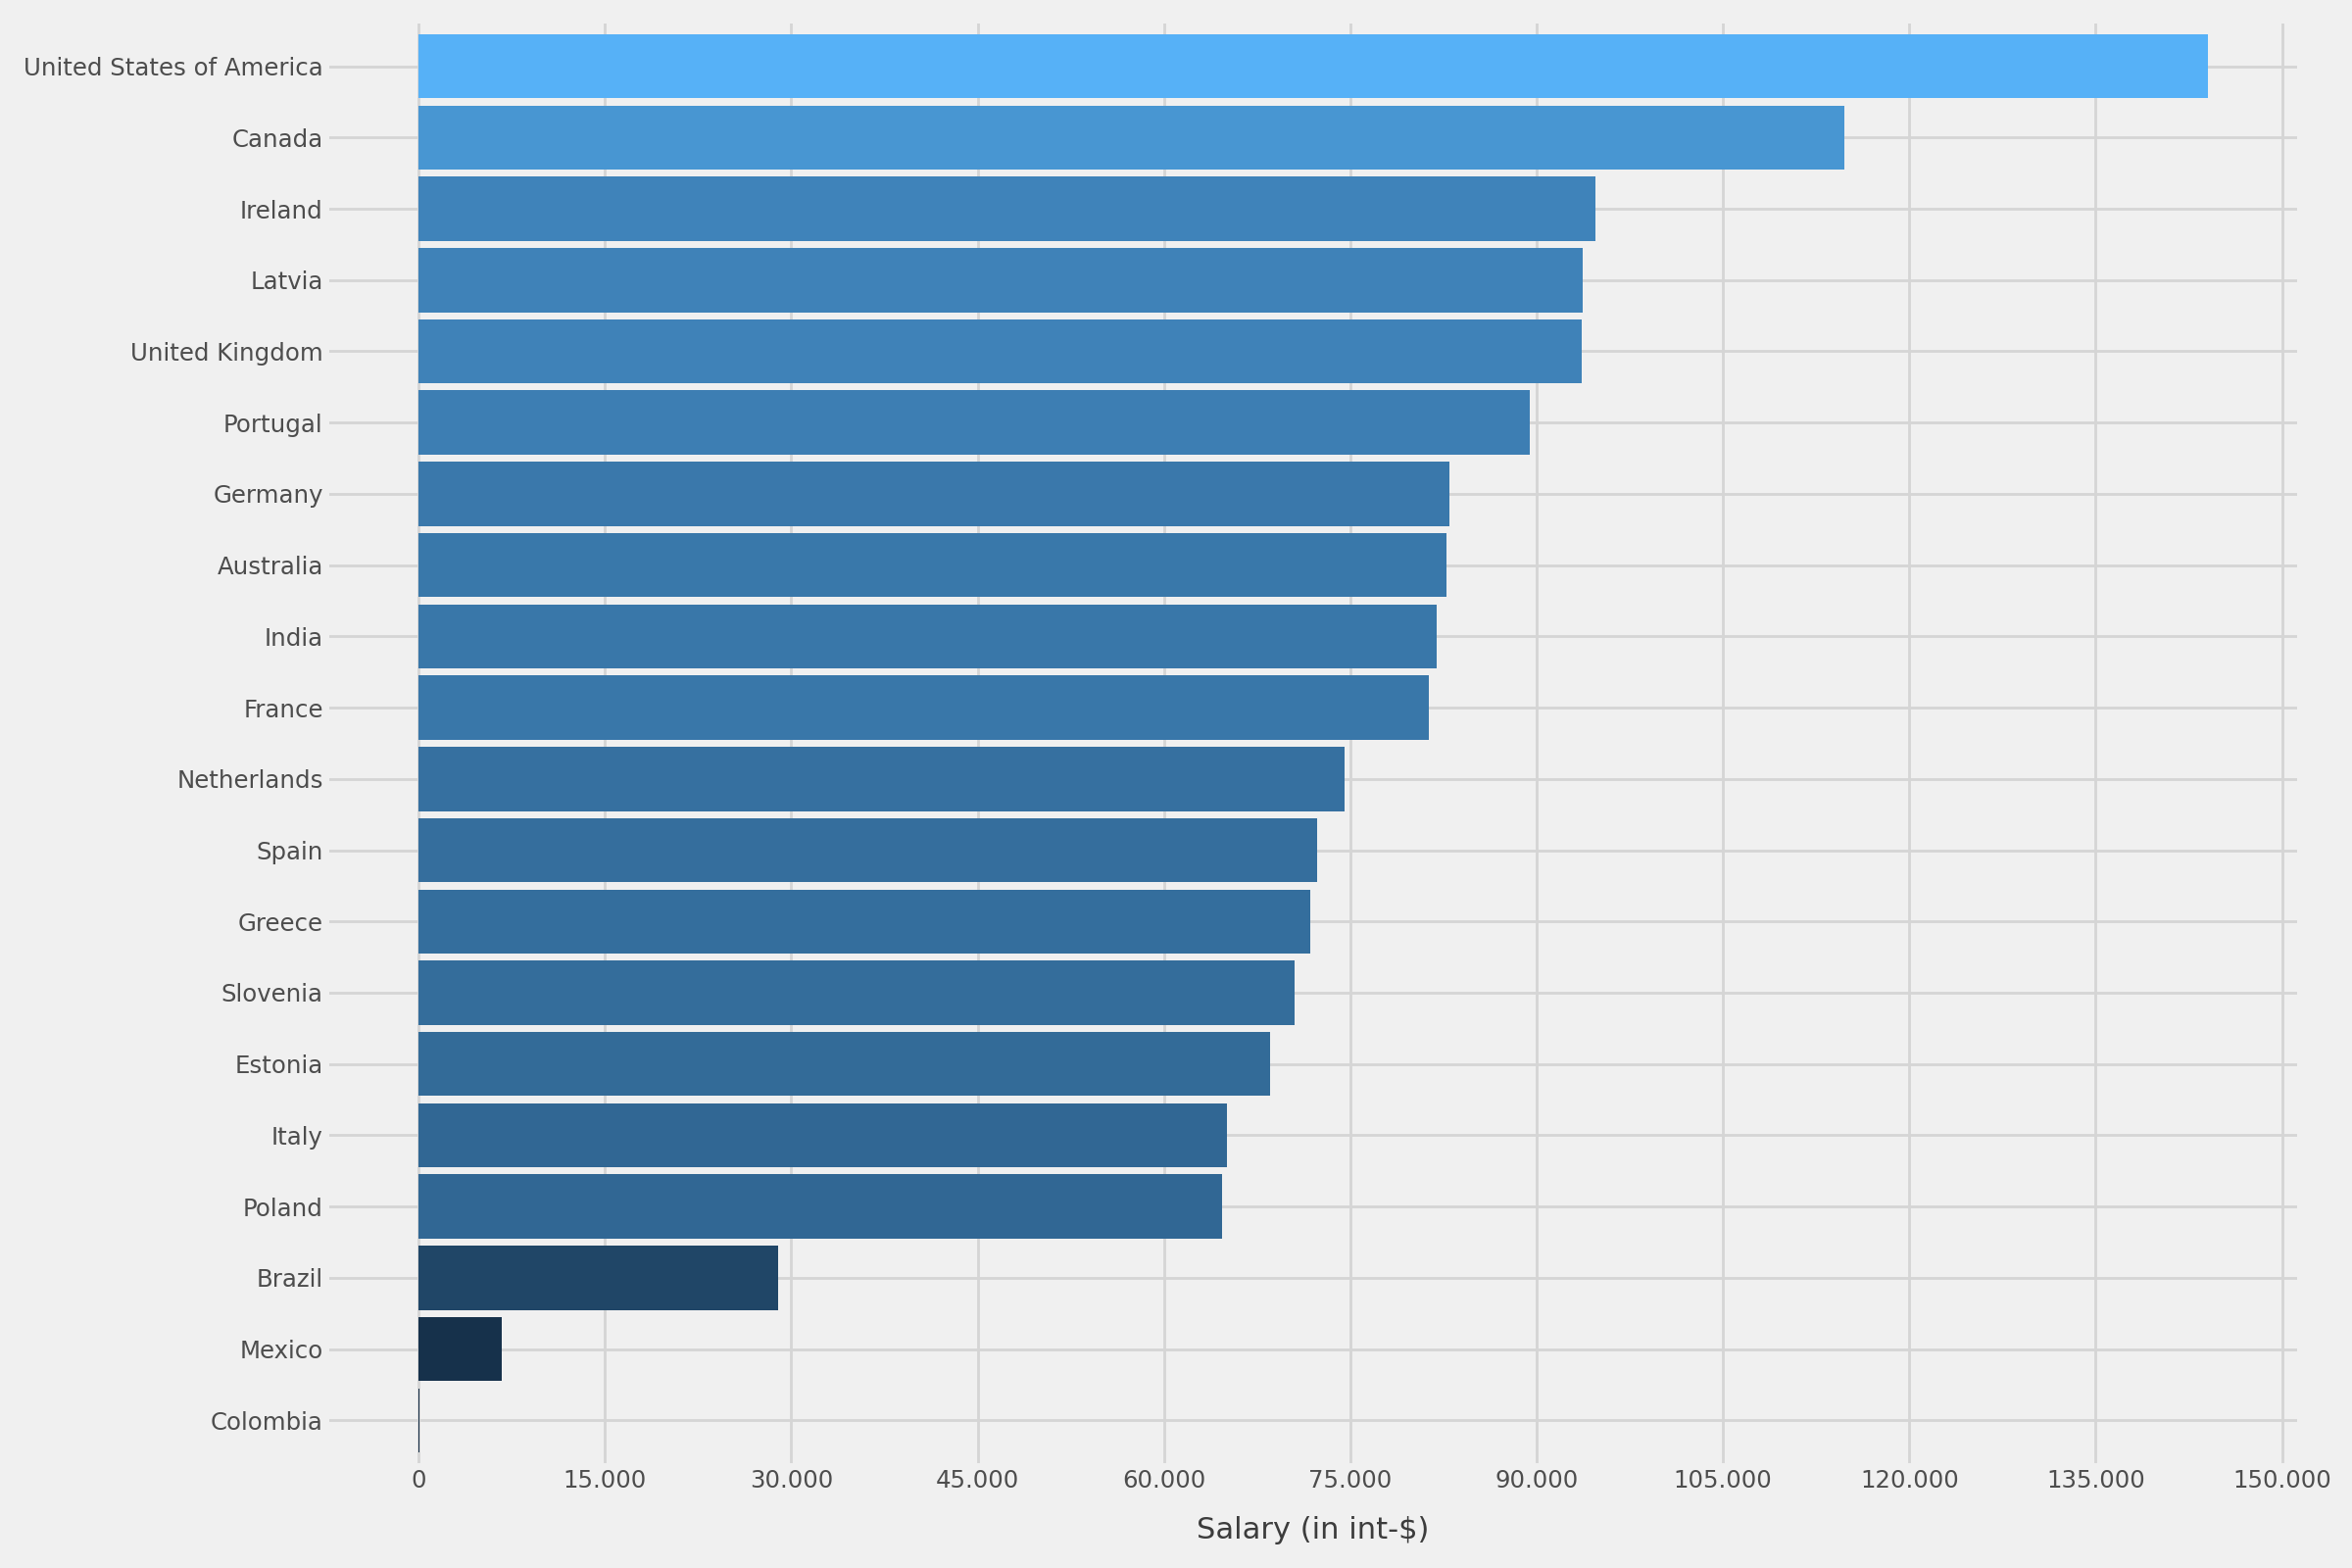

In [37]:
(
    ggplot(salary_median.dropna(), aes(x="reorder(country,salary_in_usd)", y="salary_in_usd"))  # Map x: country names reordered by salary, y: median salary
    + geom_col(aes(fill="salary_in_usd"))  # Colored bars by salary value
    + theme(figure_size=(12,8))  # Set figure size
    + coord_flip()  # Flip axes
    + labs(x="", y="Salary (in int-$)")  # Axis labels
    + scale_y_continuous(
        breaks=range(0,165000,15000),  # y-axis ticks every 15k
        labels=lambda l: [labeller1(x) for x in l],  # Format y-axis labels
    )
    + scale_fill_gradient(guide = None)  # Gradient fill for salary and remove legend
)

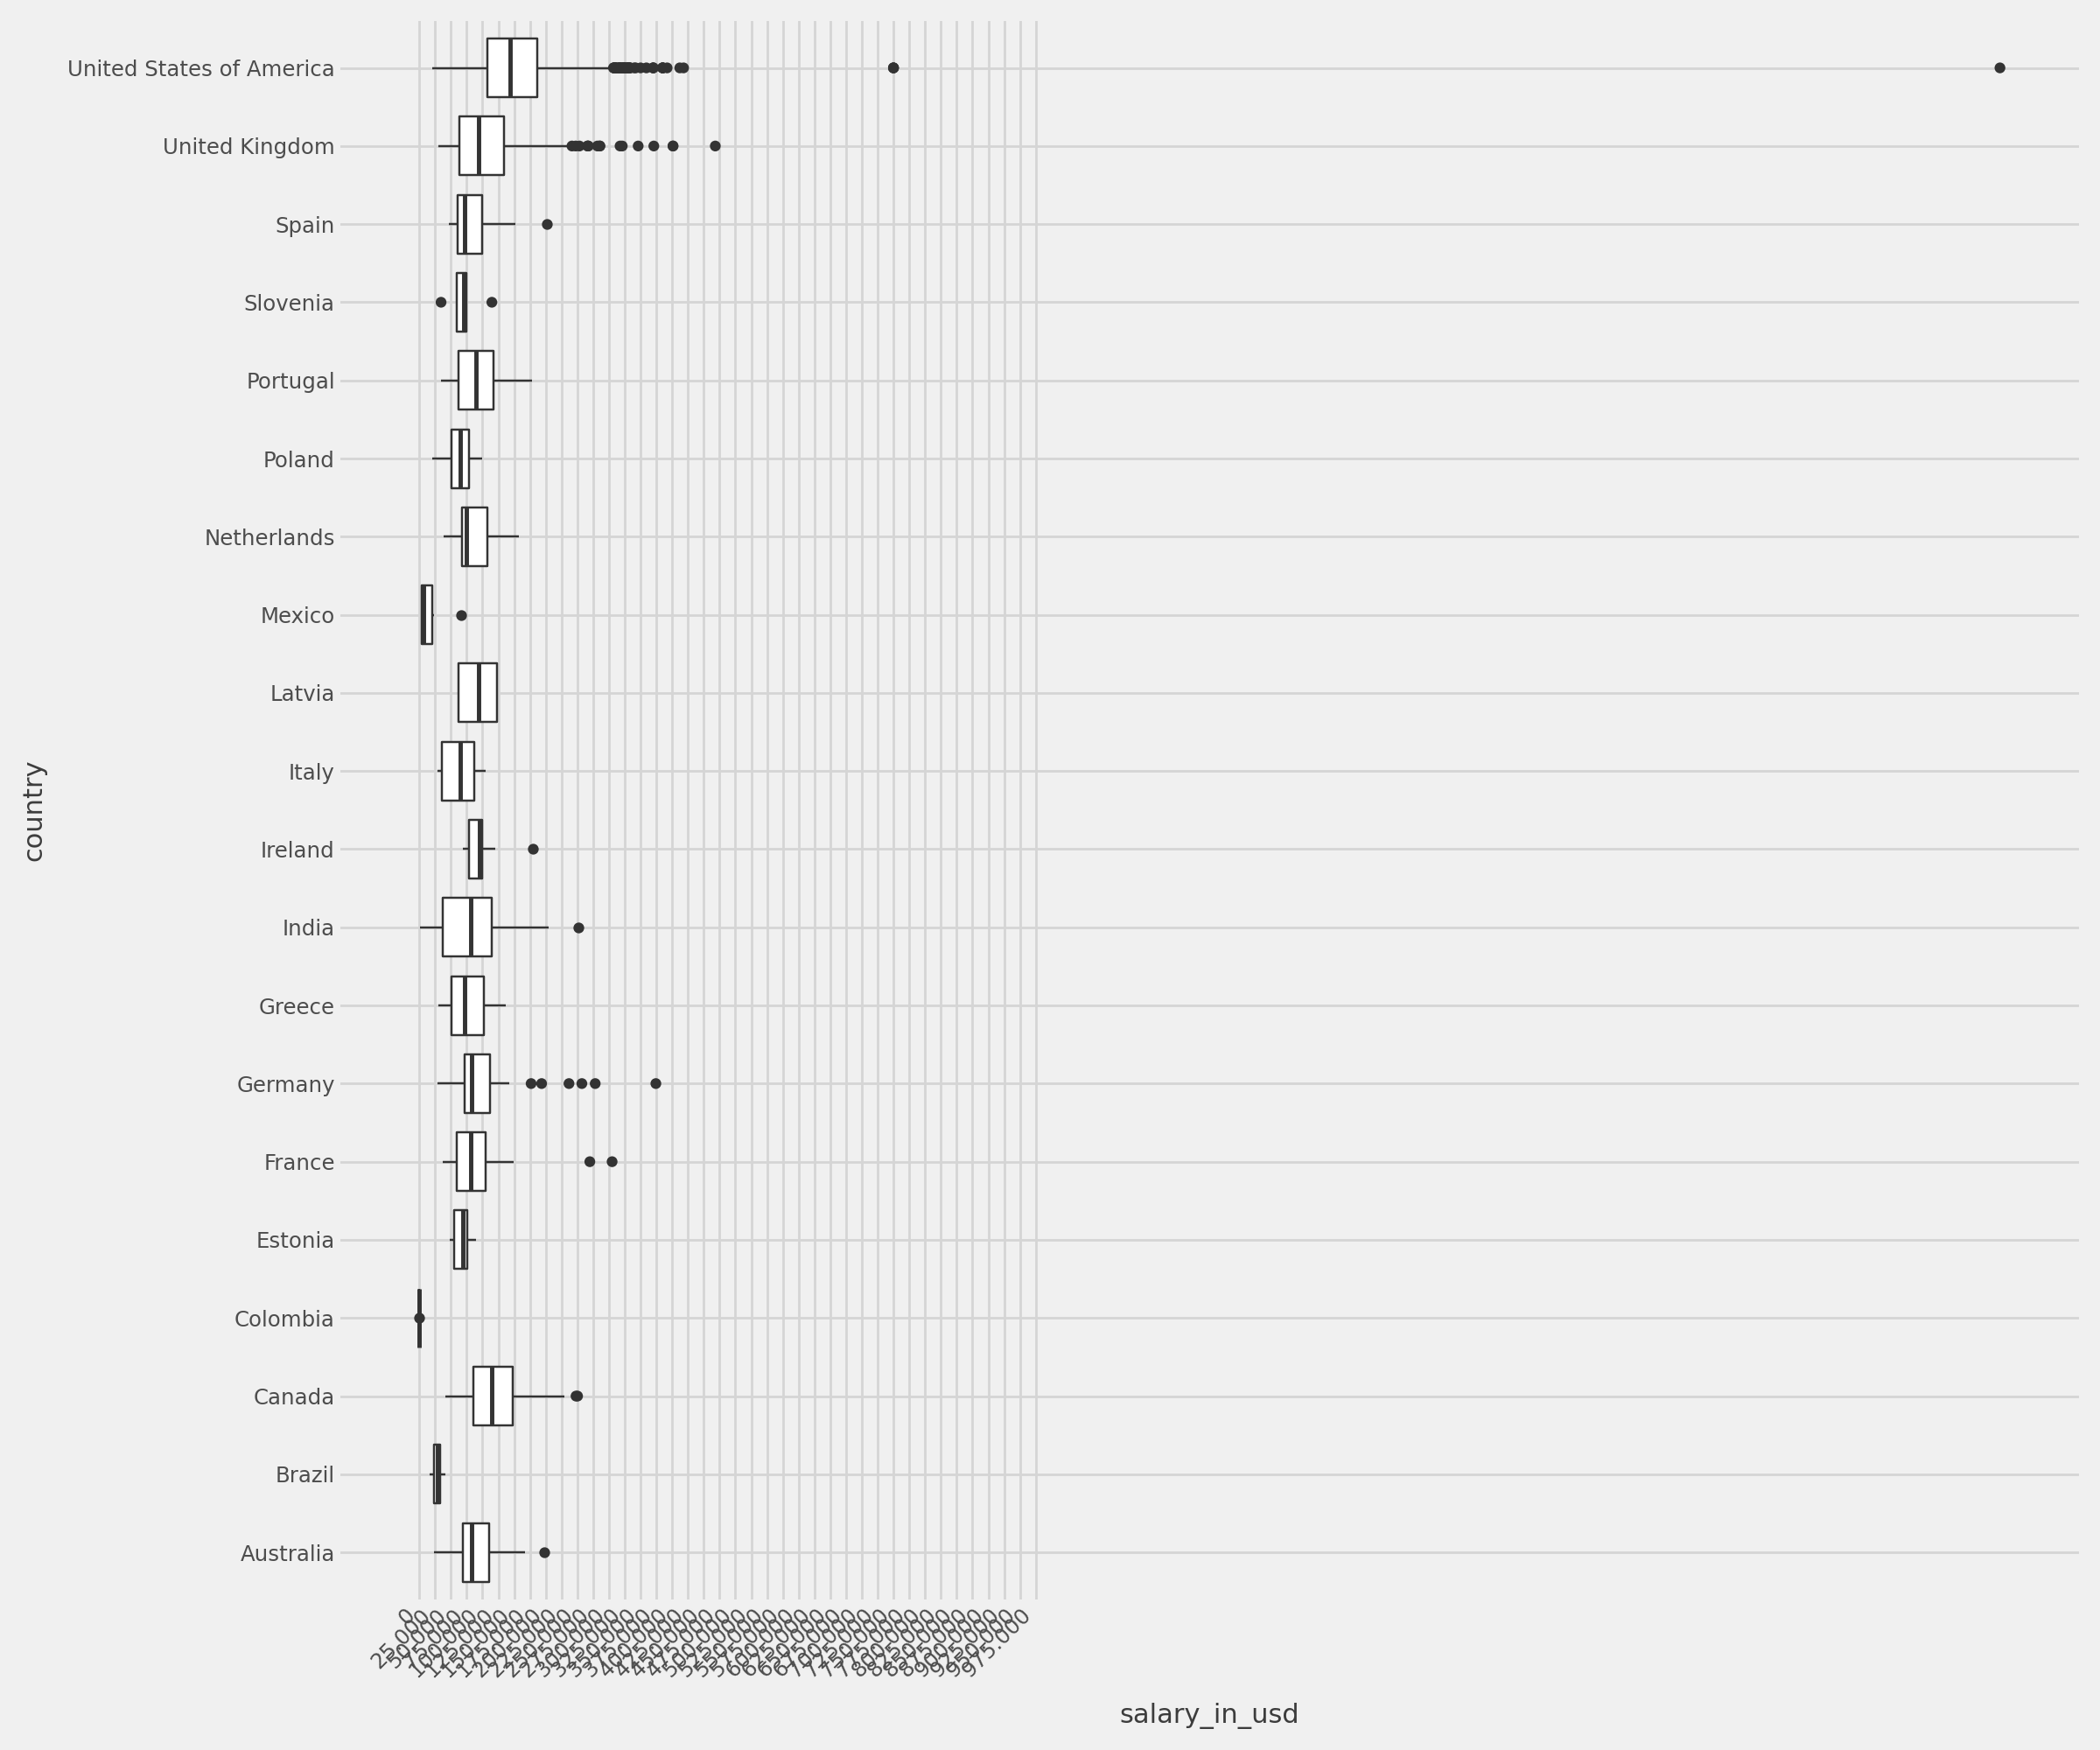

In [38]:
(
    ggplot(data, aes(x='country', y='salary_in_usd')) # Map x: company location, y: salary in USD
    + geom_boxplot() # Create boxplot
    + scale_y_continuous(breaks = range(0,1000000,25000), labels = lambda l: [labeller1(x) for x in l]) # Format y-axis labels
    + theme(figure_size=(12, 10), axis_text_x=element_text(rotation=45, ha='right')) # Customize theme
    + coord_flip() # Flip coordinates
)

In [39]:
remote_prop = data.groupby("country")["work_models"].apply(lambda x: round(len(x[x == "remote"])/len(x) * 100, 2)) # Compute percentage of remote jobs by country
remote_prop = merge(remote_prop,gdf.loc[:,"ADMIN":"geometry"], how = "right", left_on = "country", right_on = "ADMIN") # Merge with geometrical data

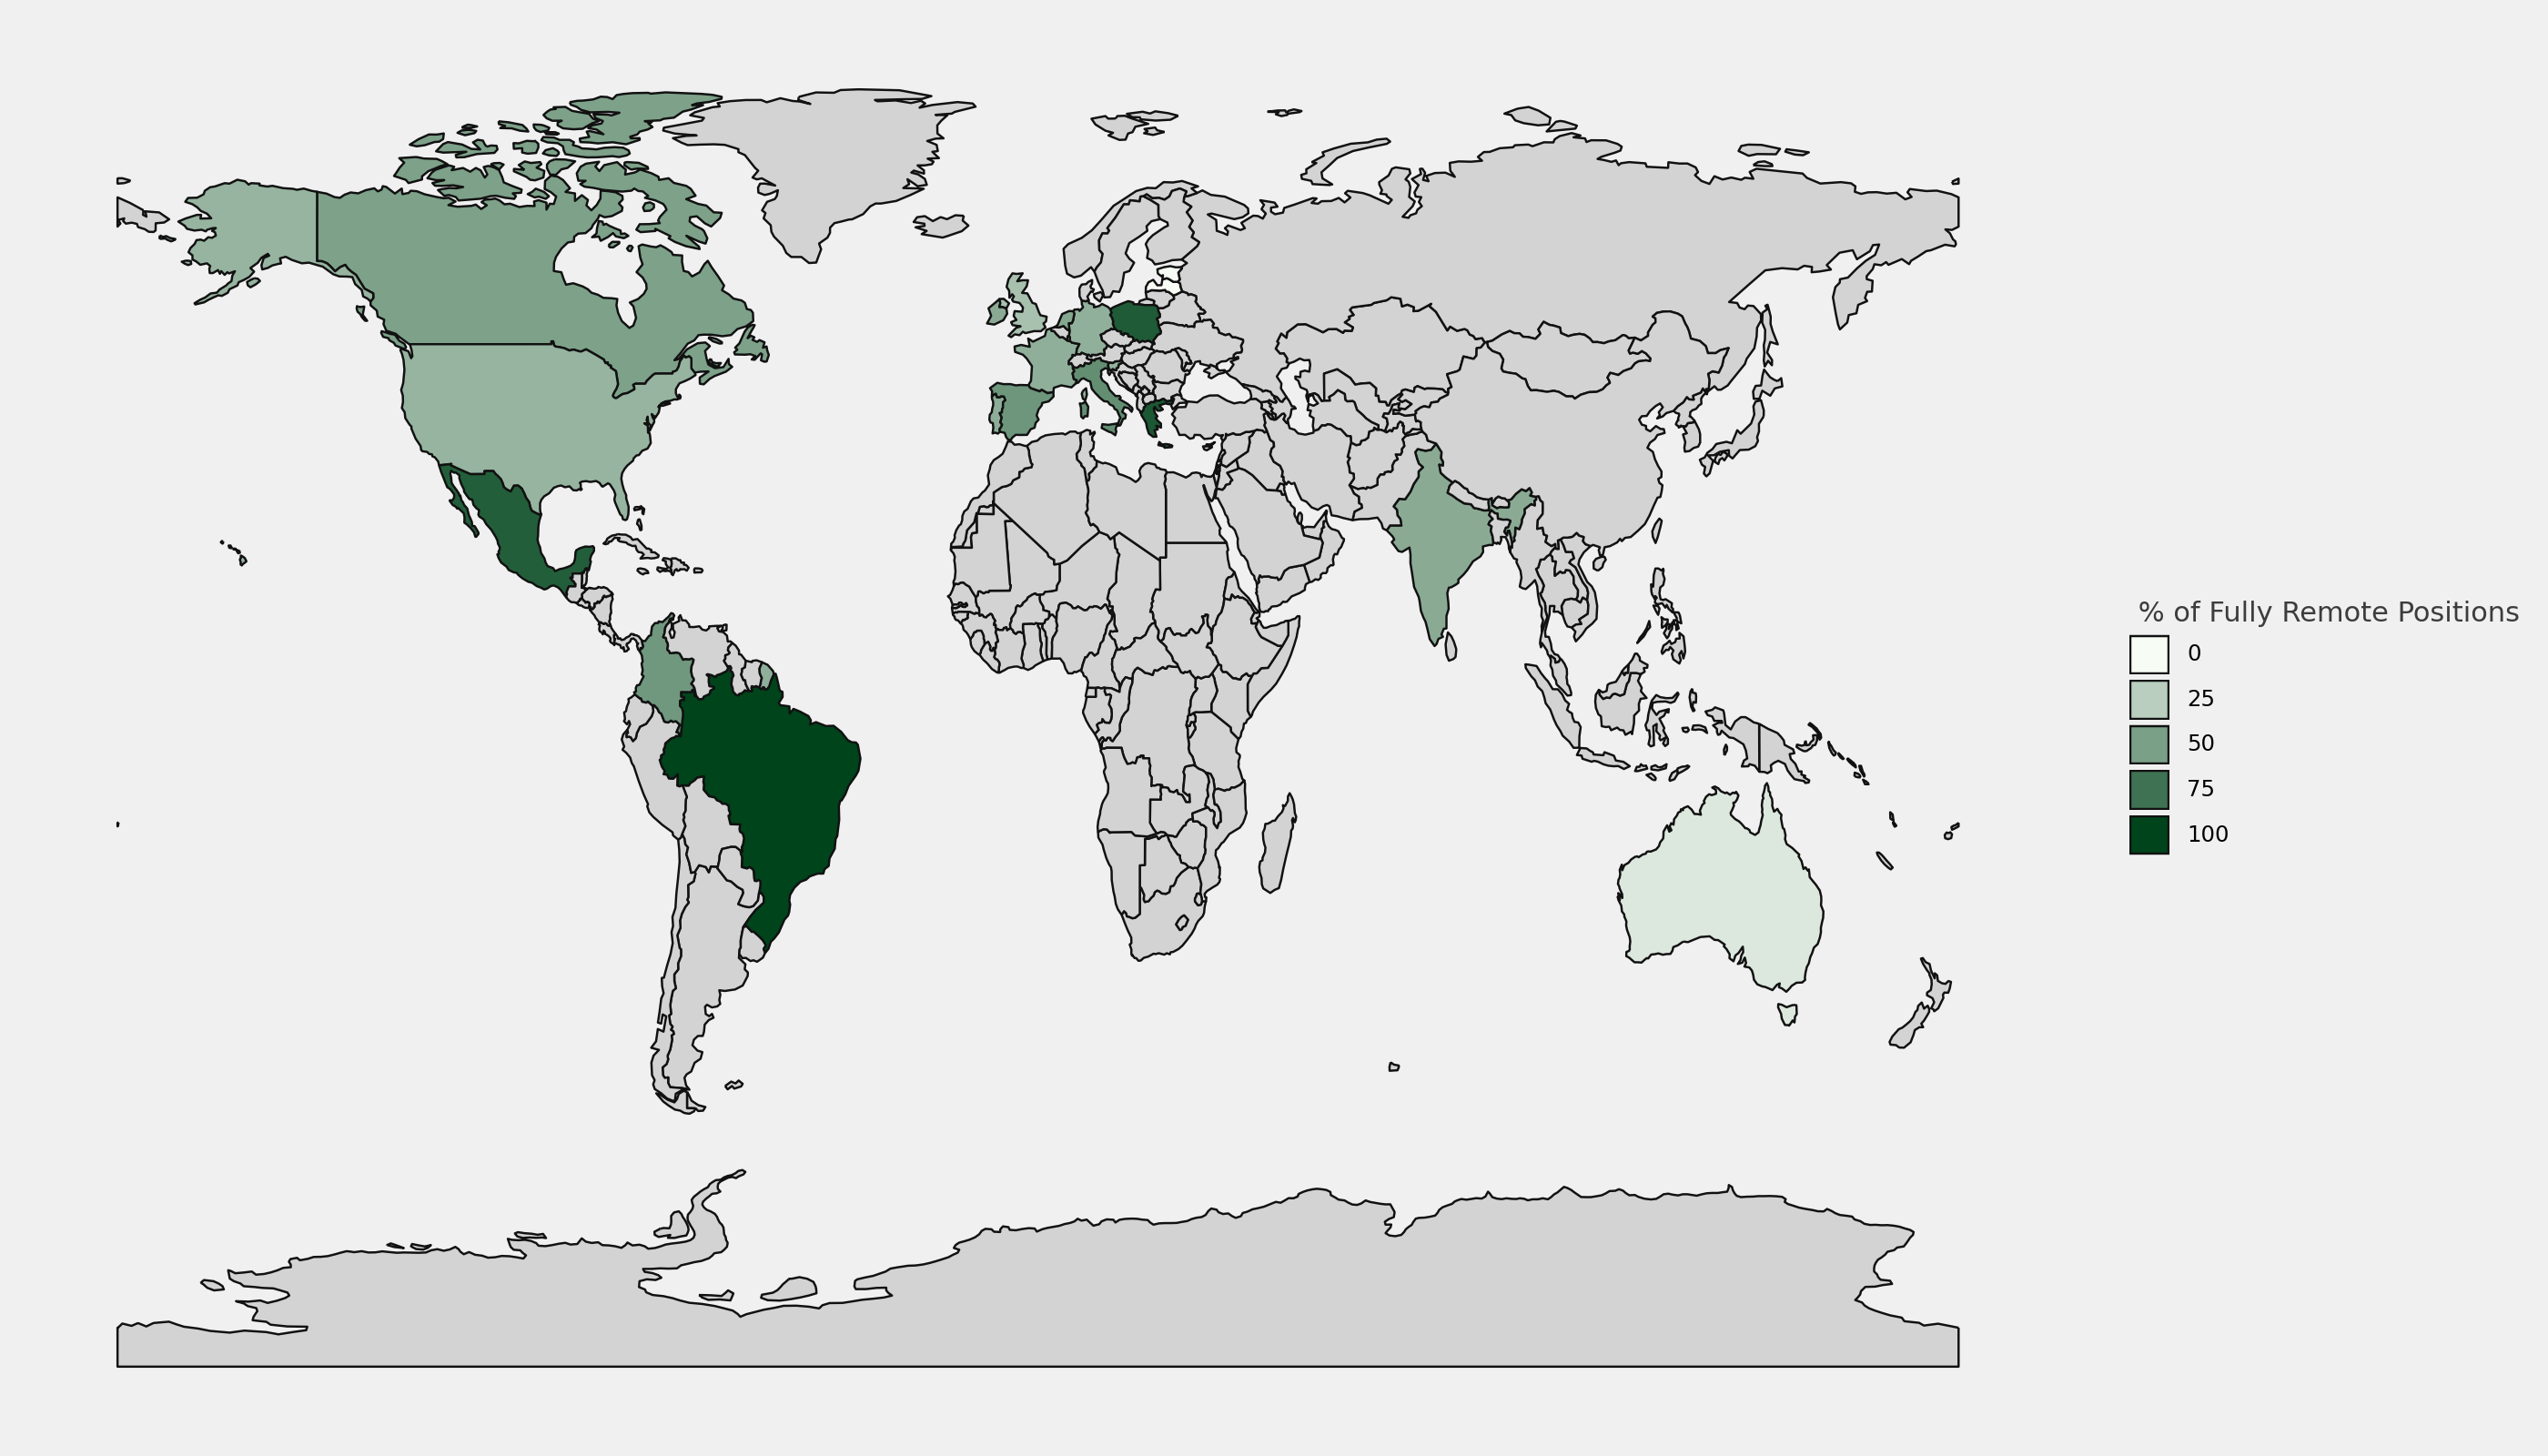

In [40]:
(
    ggplot(remote_prop, aes(fill = "work_models")) # Map fill aesthetic to work_models
    + geom_map() # Create map visualization
    + theme(figure_size=(14,8), # Customize figure size
            axis_text_x=element_blank(), # Remove x-axis text
            axis_text_y=element_blank(), # Remove y-axis text
            panel_grid=element_blank()) # Remove panel grid
    + scale_fill_gradient(name = " % of Fully Remote Positions", # Define fill gradient
                          low = "#f7fcf5", high="#00441b", # Set color range
                          guide = "legend", # Customize legend
                          na_value="lightgrey") # Define color for missing values
)

In [41]:
usa_data = data[data["country"] == "United States of America"] # Filter data for the United States
salaries_job_title= (usa_data.groupby(["job_title","work_year"]).median("salary_in_usd")).reset_index() # Compute median salary by job title and year
salaries_exp_level= (usa_data.groupby(["experience_level","work_year"]).median("salary_in_usd")).reset_index() # Compute median salary by experience level and year

2025-09-02 17:53:00 [warning  ] The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning. category=FutureWarning filename=C:\Users\Marco\AppData\Local\Temp\ipykernel_16708\1101417268.py lineno=2
2025-09-02 17:53:00 [warning  ] The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning. category=FutureWarning filename=C:\Users\Marco\AppData\Local\Temp\ipykernel_16708\1101417268.py lineno=3


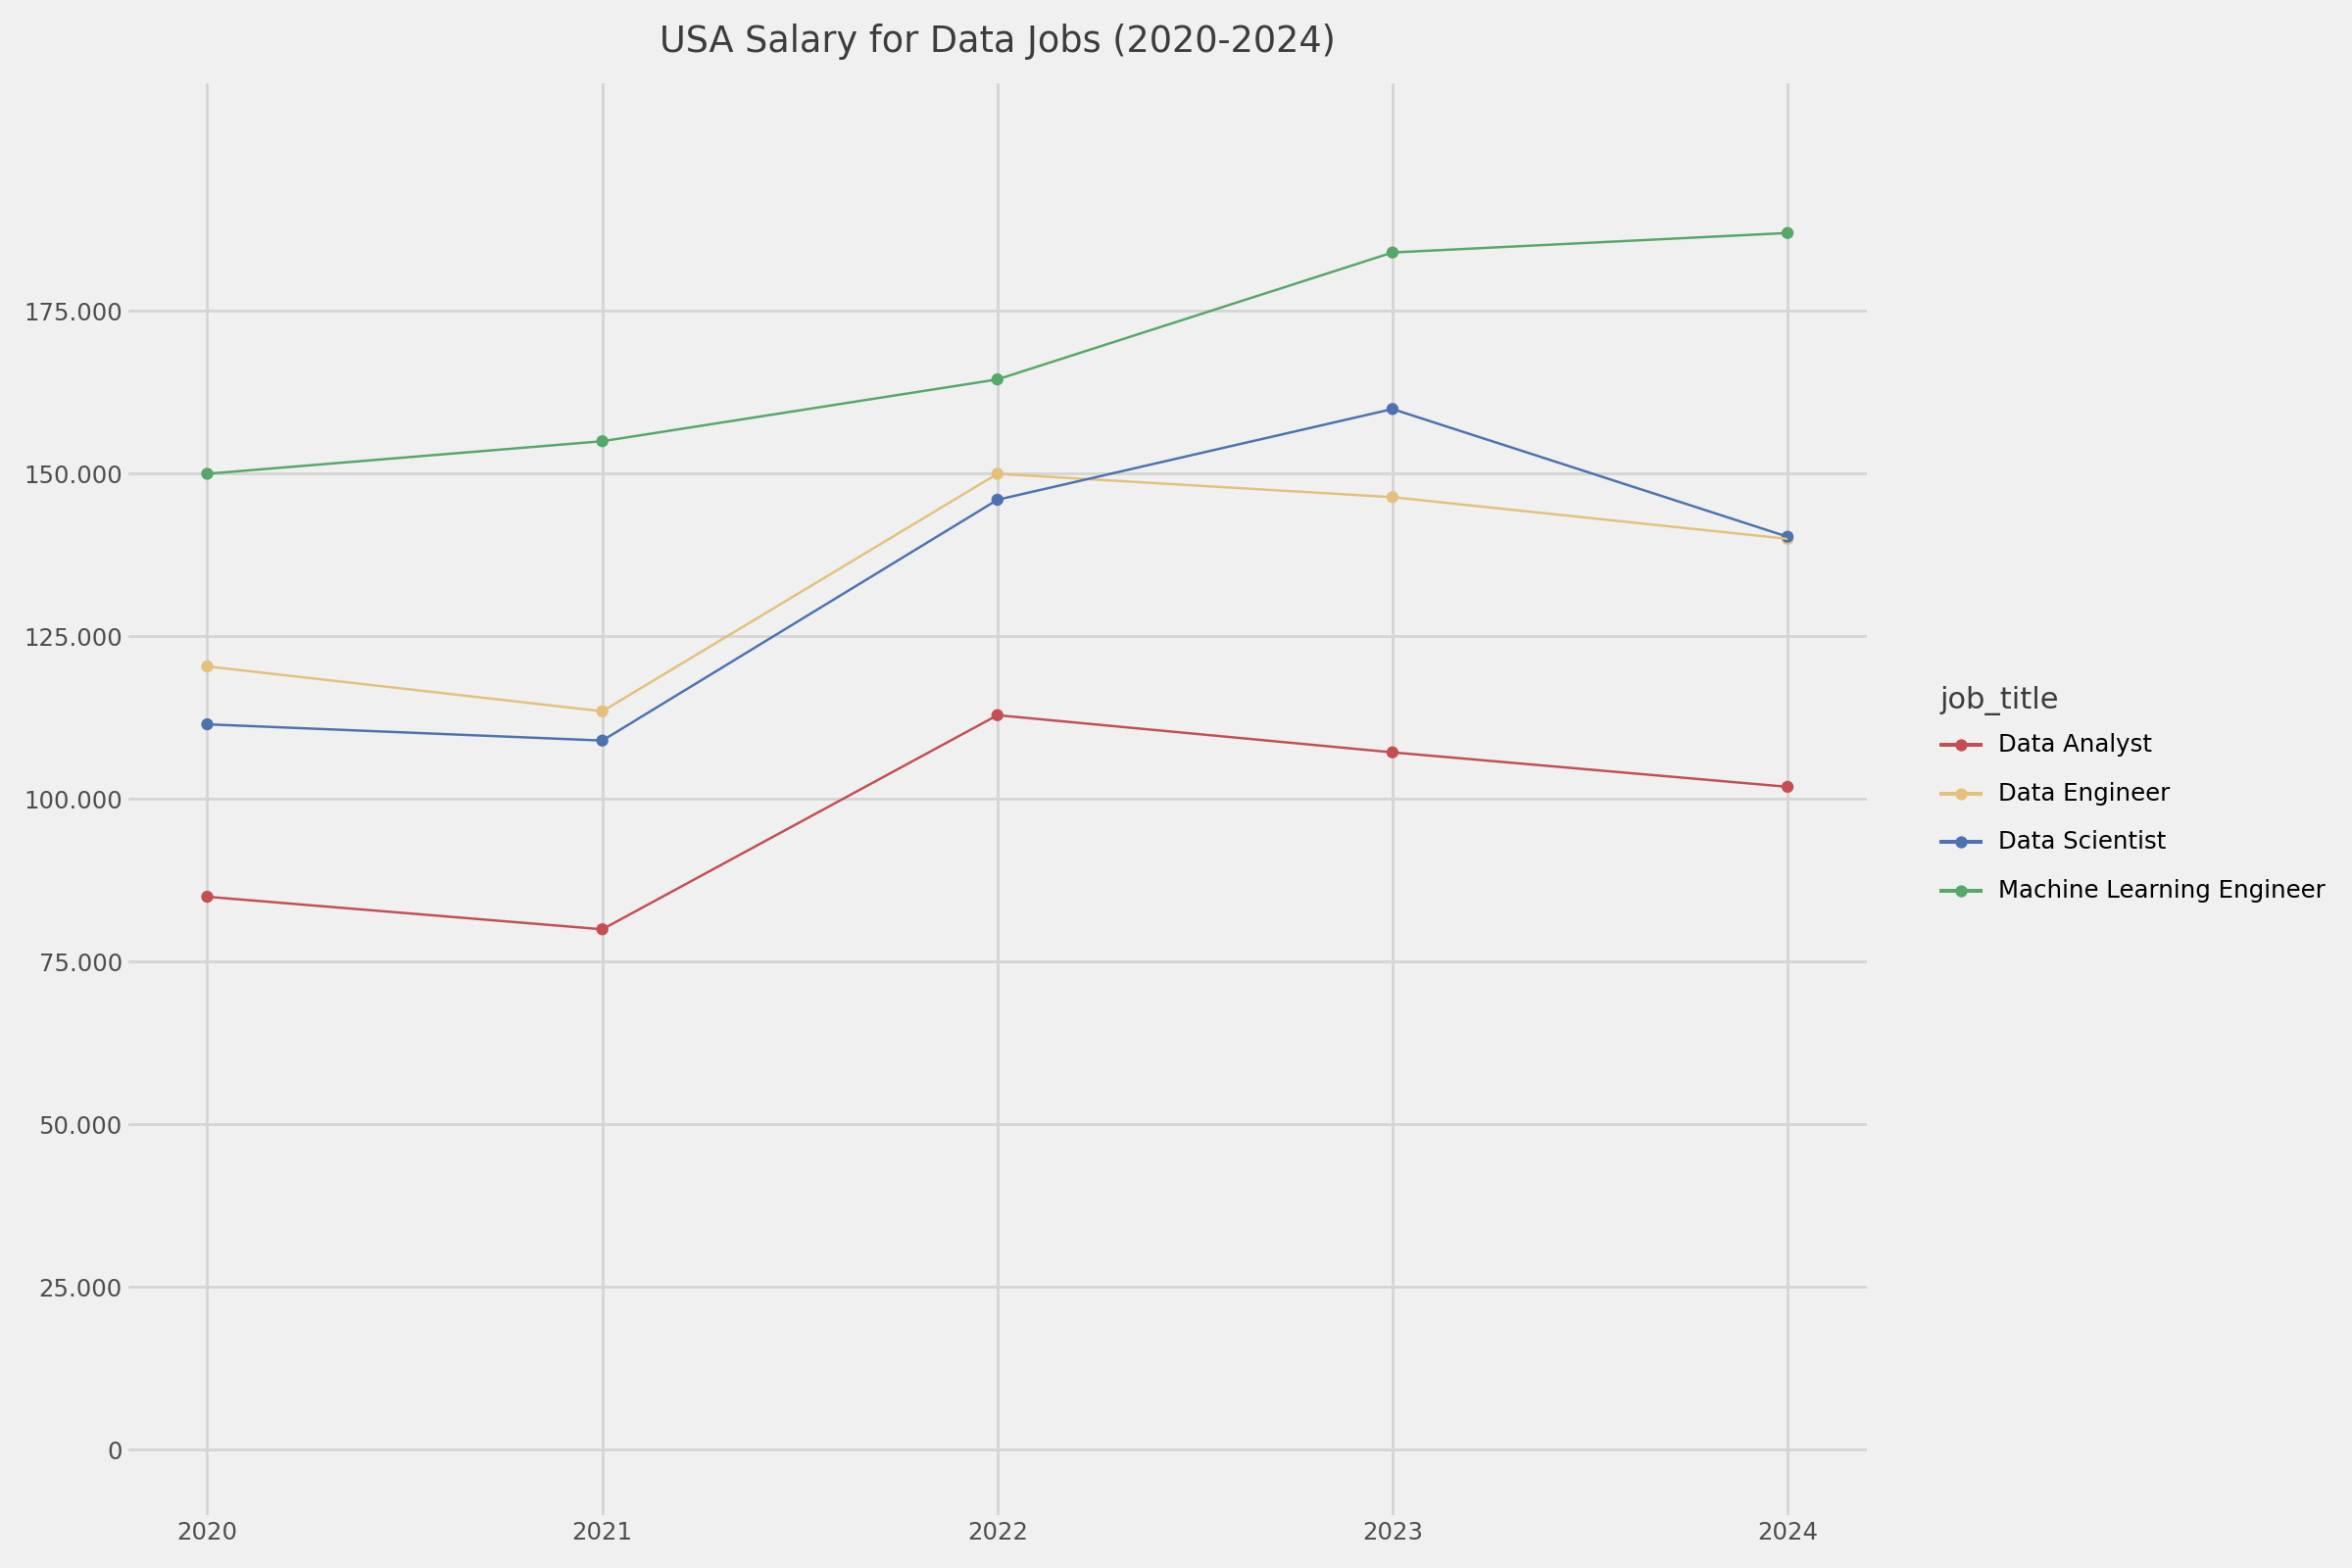

In [42]:
(
    ggplot(salaries_job_title, aes(x='work_year', y='salary_in_usd', color = 'job_title', group ='job_title')) # Map x: work year, y: salary in USD
    + geom_point() # Add point geometry
    + geom_line() # Add line geometry
    + scale_color_manual(cols,  # Define custom color scale
                         labels = lambda l: [x.title() for x in l]) # Format color labels
    + scale_y_continuous(labels = lambda l: [labeller1(x) for x in l], limits = (0,200000), breaks = range(0,200000,25000))  # Define y-axis breaks and labels
    + labs(title = "USA Salary for Data Jobs (2020-2024)", x = "",y = "") # Add labels
    + theme(figure_size=(12,8)) # Customize theme
)

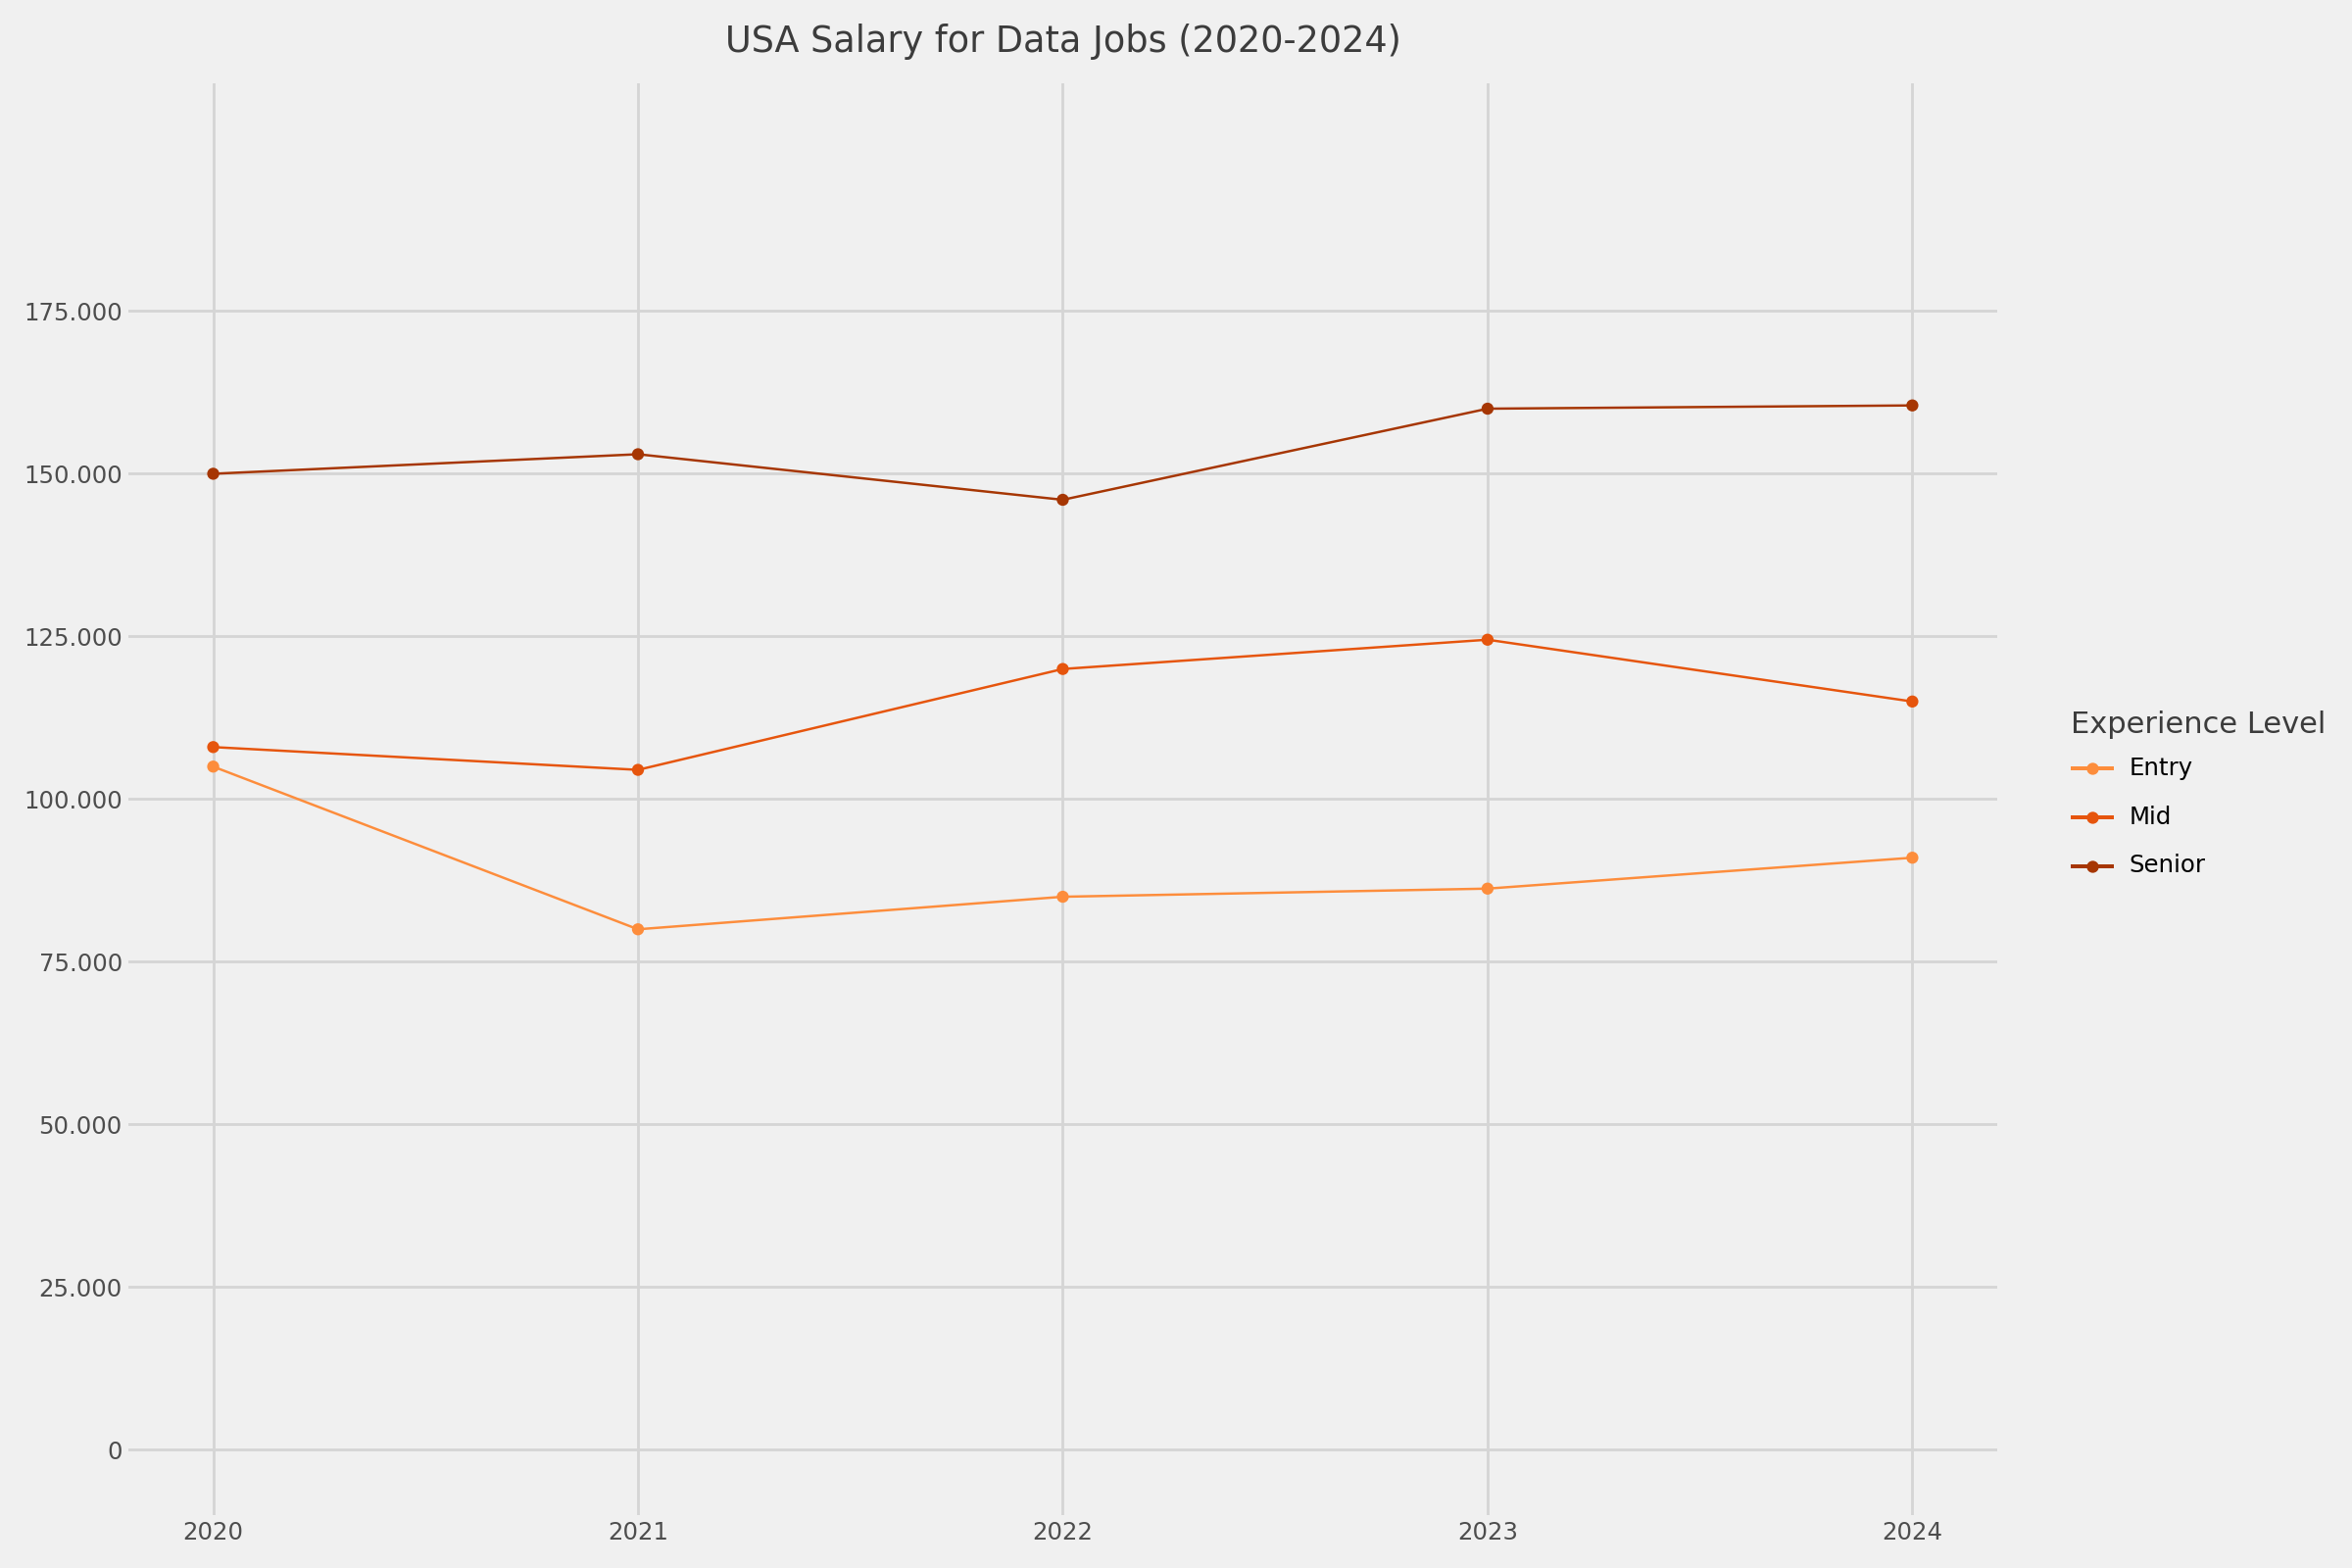

In [43]:
(
    ggplot(salaries_exp_level, aes(x='work_year', y='salary_in_usd', color = 'experience_level', group ='experience_level'))  # Map x: work year, y: salary in USD
    + scale_y_continuous(labels = lambda l: [labeller1(x) for x in l], limits = (0,200000), breaks = range(0,200000,25000))  # Define y-axis breaks and labels
    + geom_point() # Add point geometry
    + geom_line() # Add line geometry
    + scale_color_manual(values = ["#fd8d3c","#e6550d","#a63603"], # Define custom color scale
                         labels = lambda l: [x.title() for x in l]) # Format color labels
    + labs(title = "USA Salary for Data Jobs (2020-2024)", x = "",y = "", color = "Experience Level") # Add labels
    + theme(figure_size=(12,8)) # Customize theme
)

In [44]:
hiring_per_year = data.groupby(["company_size", "work_year","job_title"]).count().reset_index().loc[:,["company_size","work_year","job_title","experience_level"]].rename(columns = {"experience_level": "job_positions"}) # Compute number of job positions by company size, year, and title
hiring_per_year.replace(0,nan, inplace = True) # Replace 0 with NaN

2025-09-02 17:53:01 [warning  ] The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning. category=FutureWarning filename=C:\Users\Marco\AppData\Local\Temp\ipykernel_16708\2170869658.py lineno=1


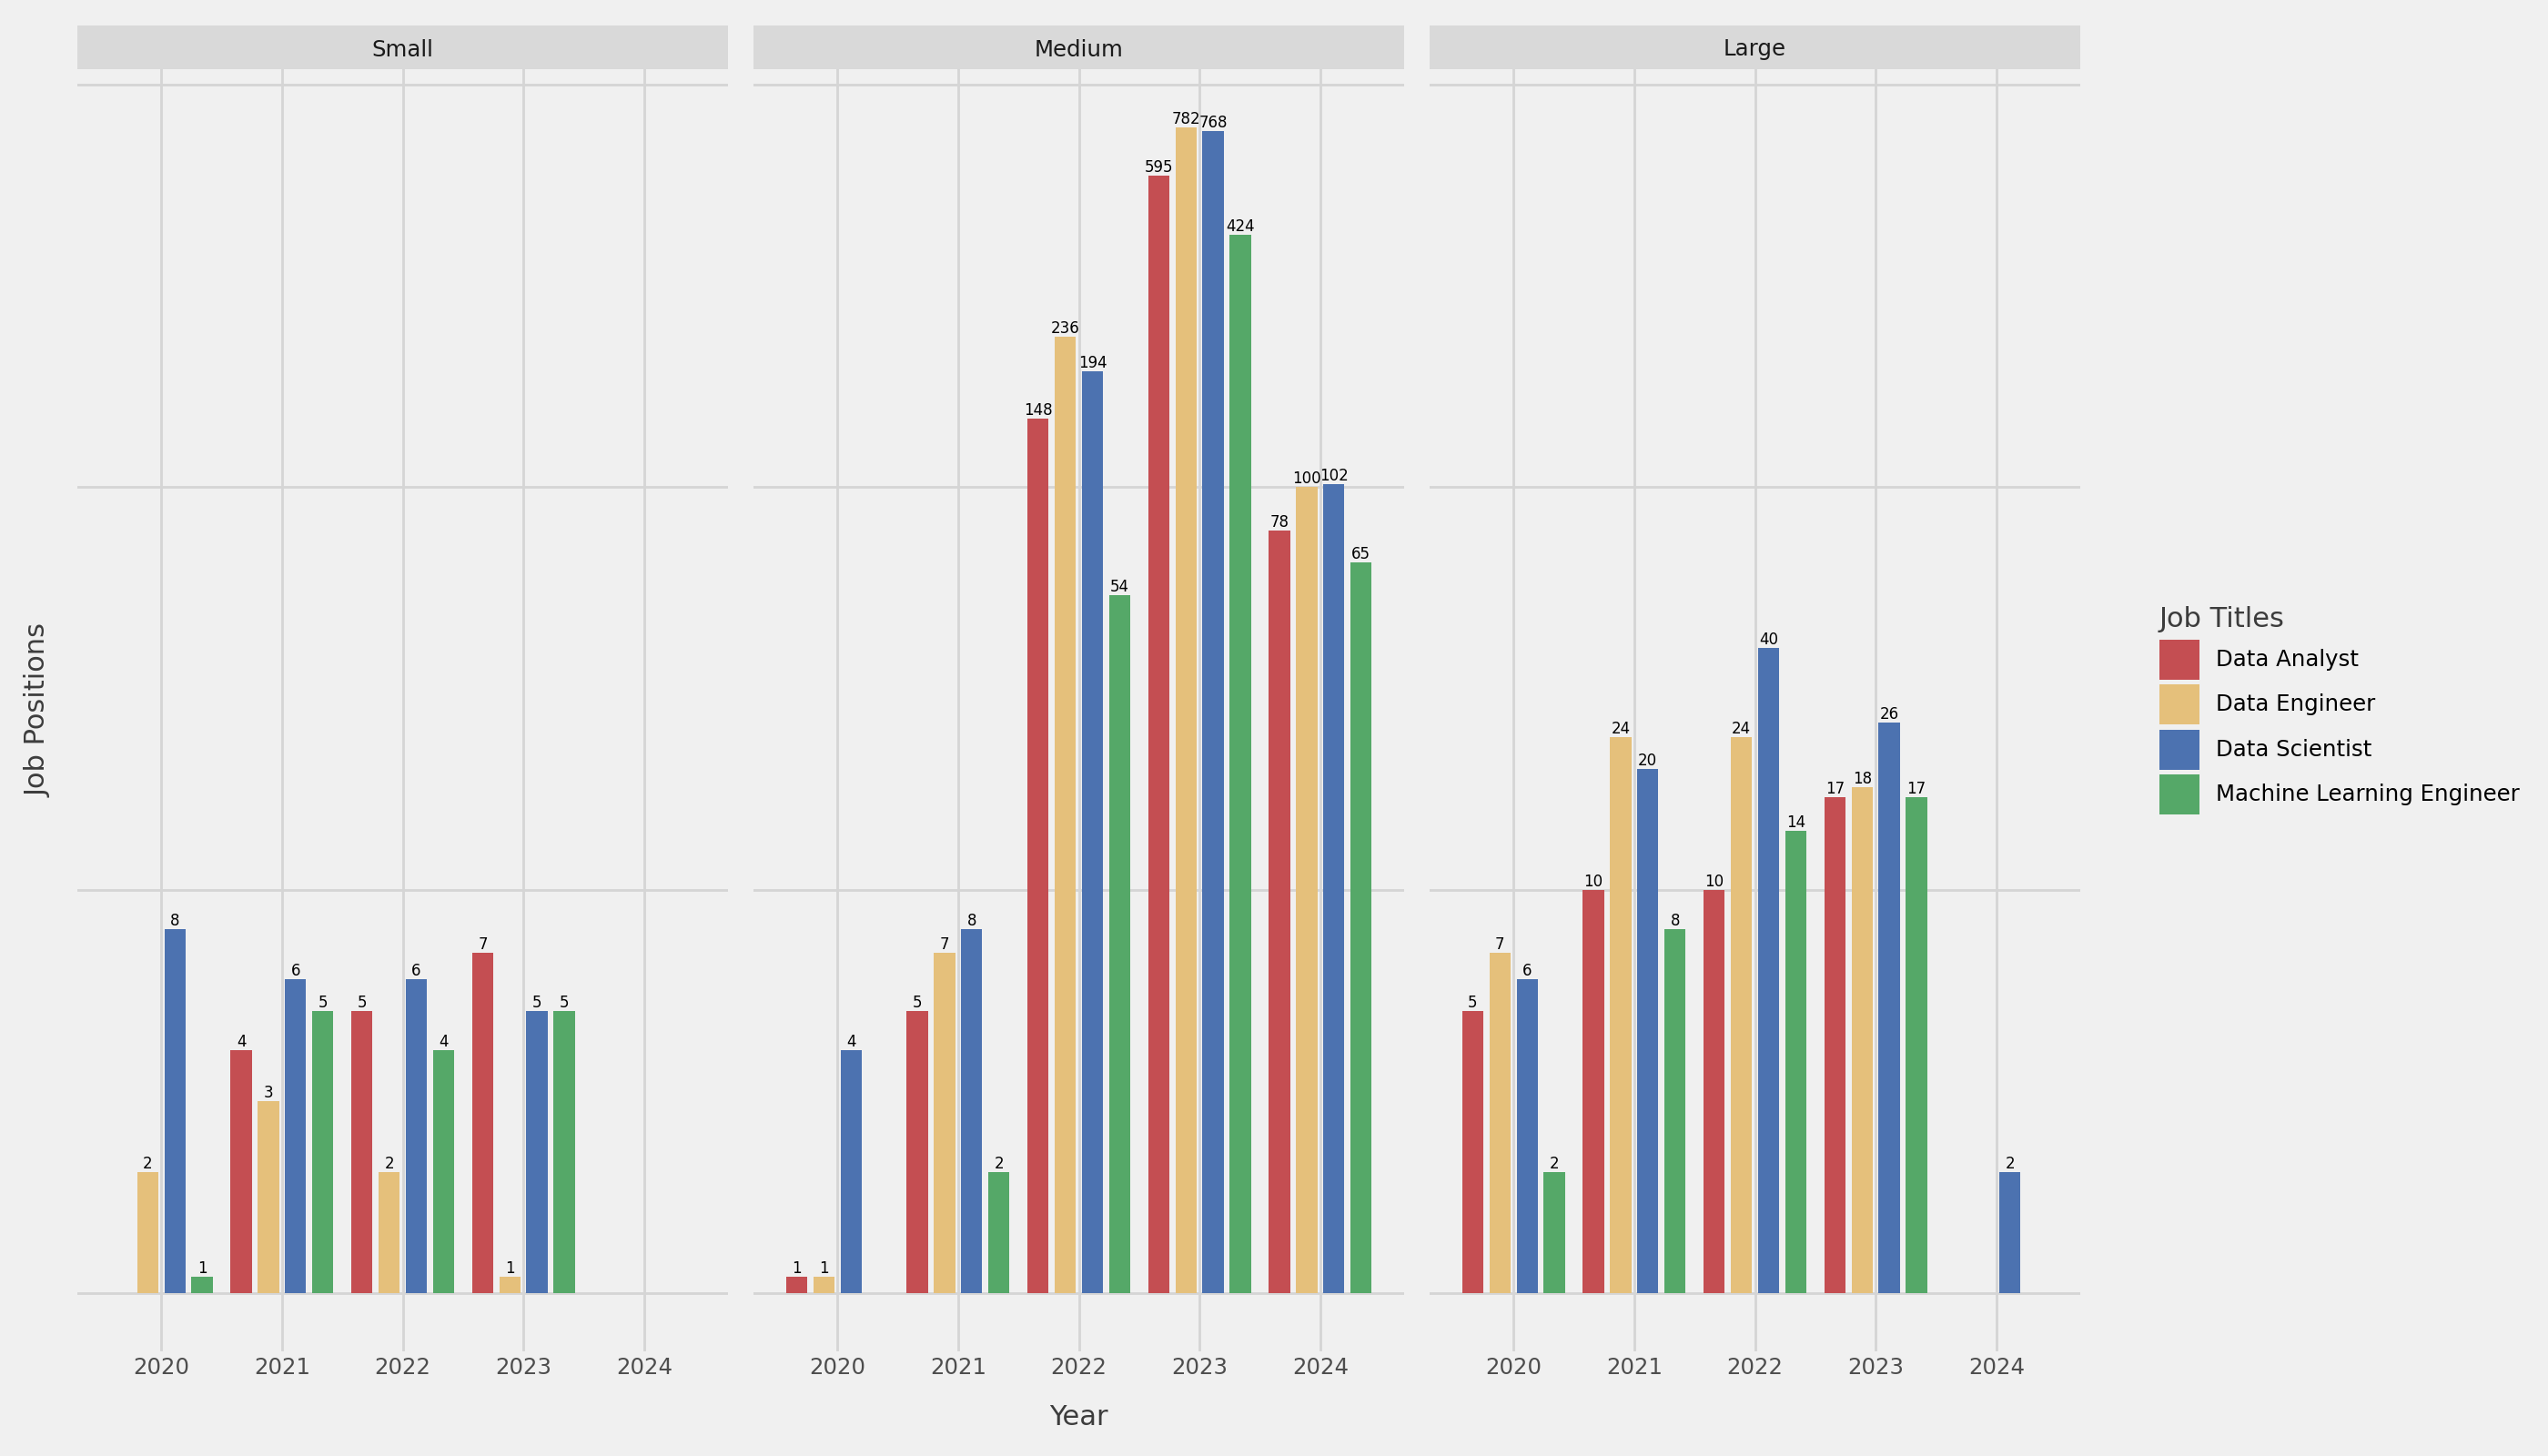

In [45]:
(
    ggplot(hiring_per_year.replace(1,1.1), aes(x='work_year', y = 'job_positions', fill = 'job_title'))  # Map x: work year, y: job positions
    + geom_col(position=position_dodge(width=0.9), # Add column geometry
               width=0.7, # Set column width
               na_rm=True) # Remove missing values
    + geom_text(aes(label = 'job_positions'), # Add text labels
                size = 6, # Set text size
                position=position_dodge(width=0.9), # Adjust position for dodging
                va='bottom', # Set vertical alignment
                format_string = "{:.0f}", # Format string for labels
                na_rm=True) # Remove missing values
    + scale_y_log10() # Set y-axis to logarithmic scale
    + scale_fill_manual(cols, # Set custom fill colors
                        labels = lambda l: [x.title() for x in l]) # Format fill labels
    + facet_grid(cols = "company_size", # Create facet grid by company size
                 labeller = lambda x: x.capitalize()) # Capitalize facet labels
    + theme(figure_size=(14,8), # Customize figure size
            axis_text_y=element_blank(), # Remove y-axis text
            axis_ticks_y=element_blank()) # Remove y-axis ticks
    + labs(x = "Year",y = "Job Positions", fill = "Job Titles") # Add labels

)

In [46]:
valid_countries_gini = counts[counts >= 10].index # Countries with at least 10 samples

def gini(x): # Define function to compute Gini index
    total = 0
    for i, xi in enumerate(x[:-1], 1):
        total += sum(abs(xi - x[i:]))
    return total / (len(x)**2 * mean(x))

gini_index = data.loc[:,["country","job_title","salary_in_usd","company_size"]]
gini_index=gini_index.groupby(["country","job_title"])["salary_in_usd"].apply(lambda x: gini(x)).reset_index().rename(columns = {"salary_in_usd": "gini_index"})

2025-09-02 17:53:01 [warning  ] The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning. category=FutureWarning filename=C:\Users\Marco\AppData\Local\Temp\ipykernel_16708\716744605.py lineno=10


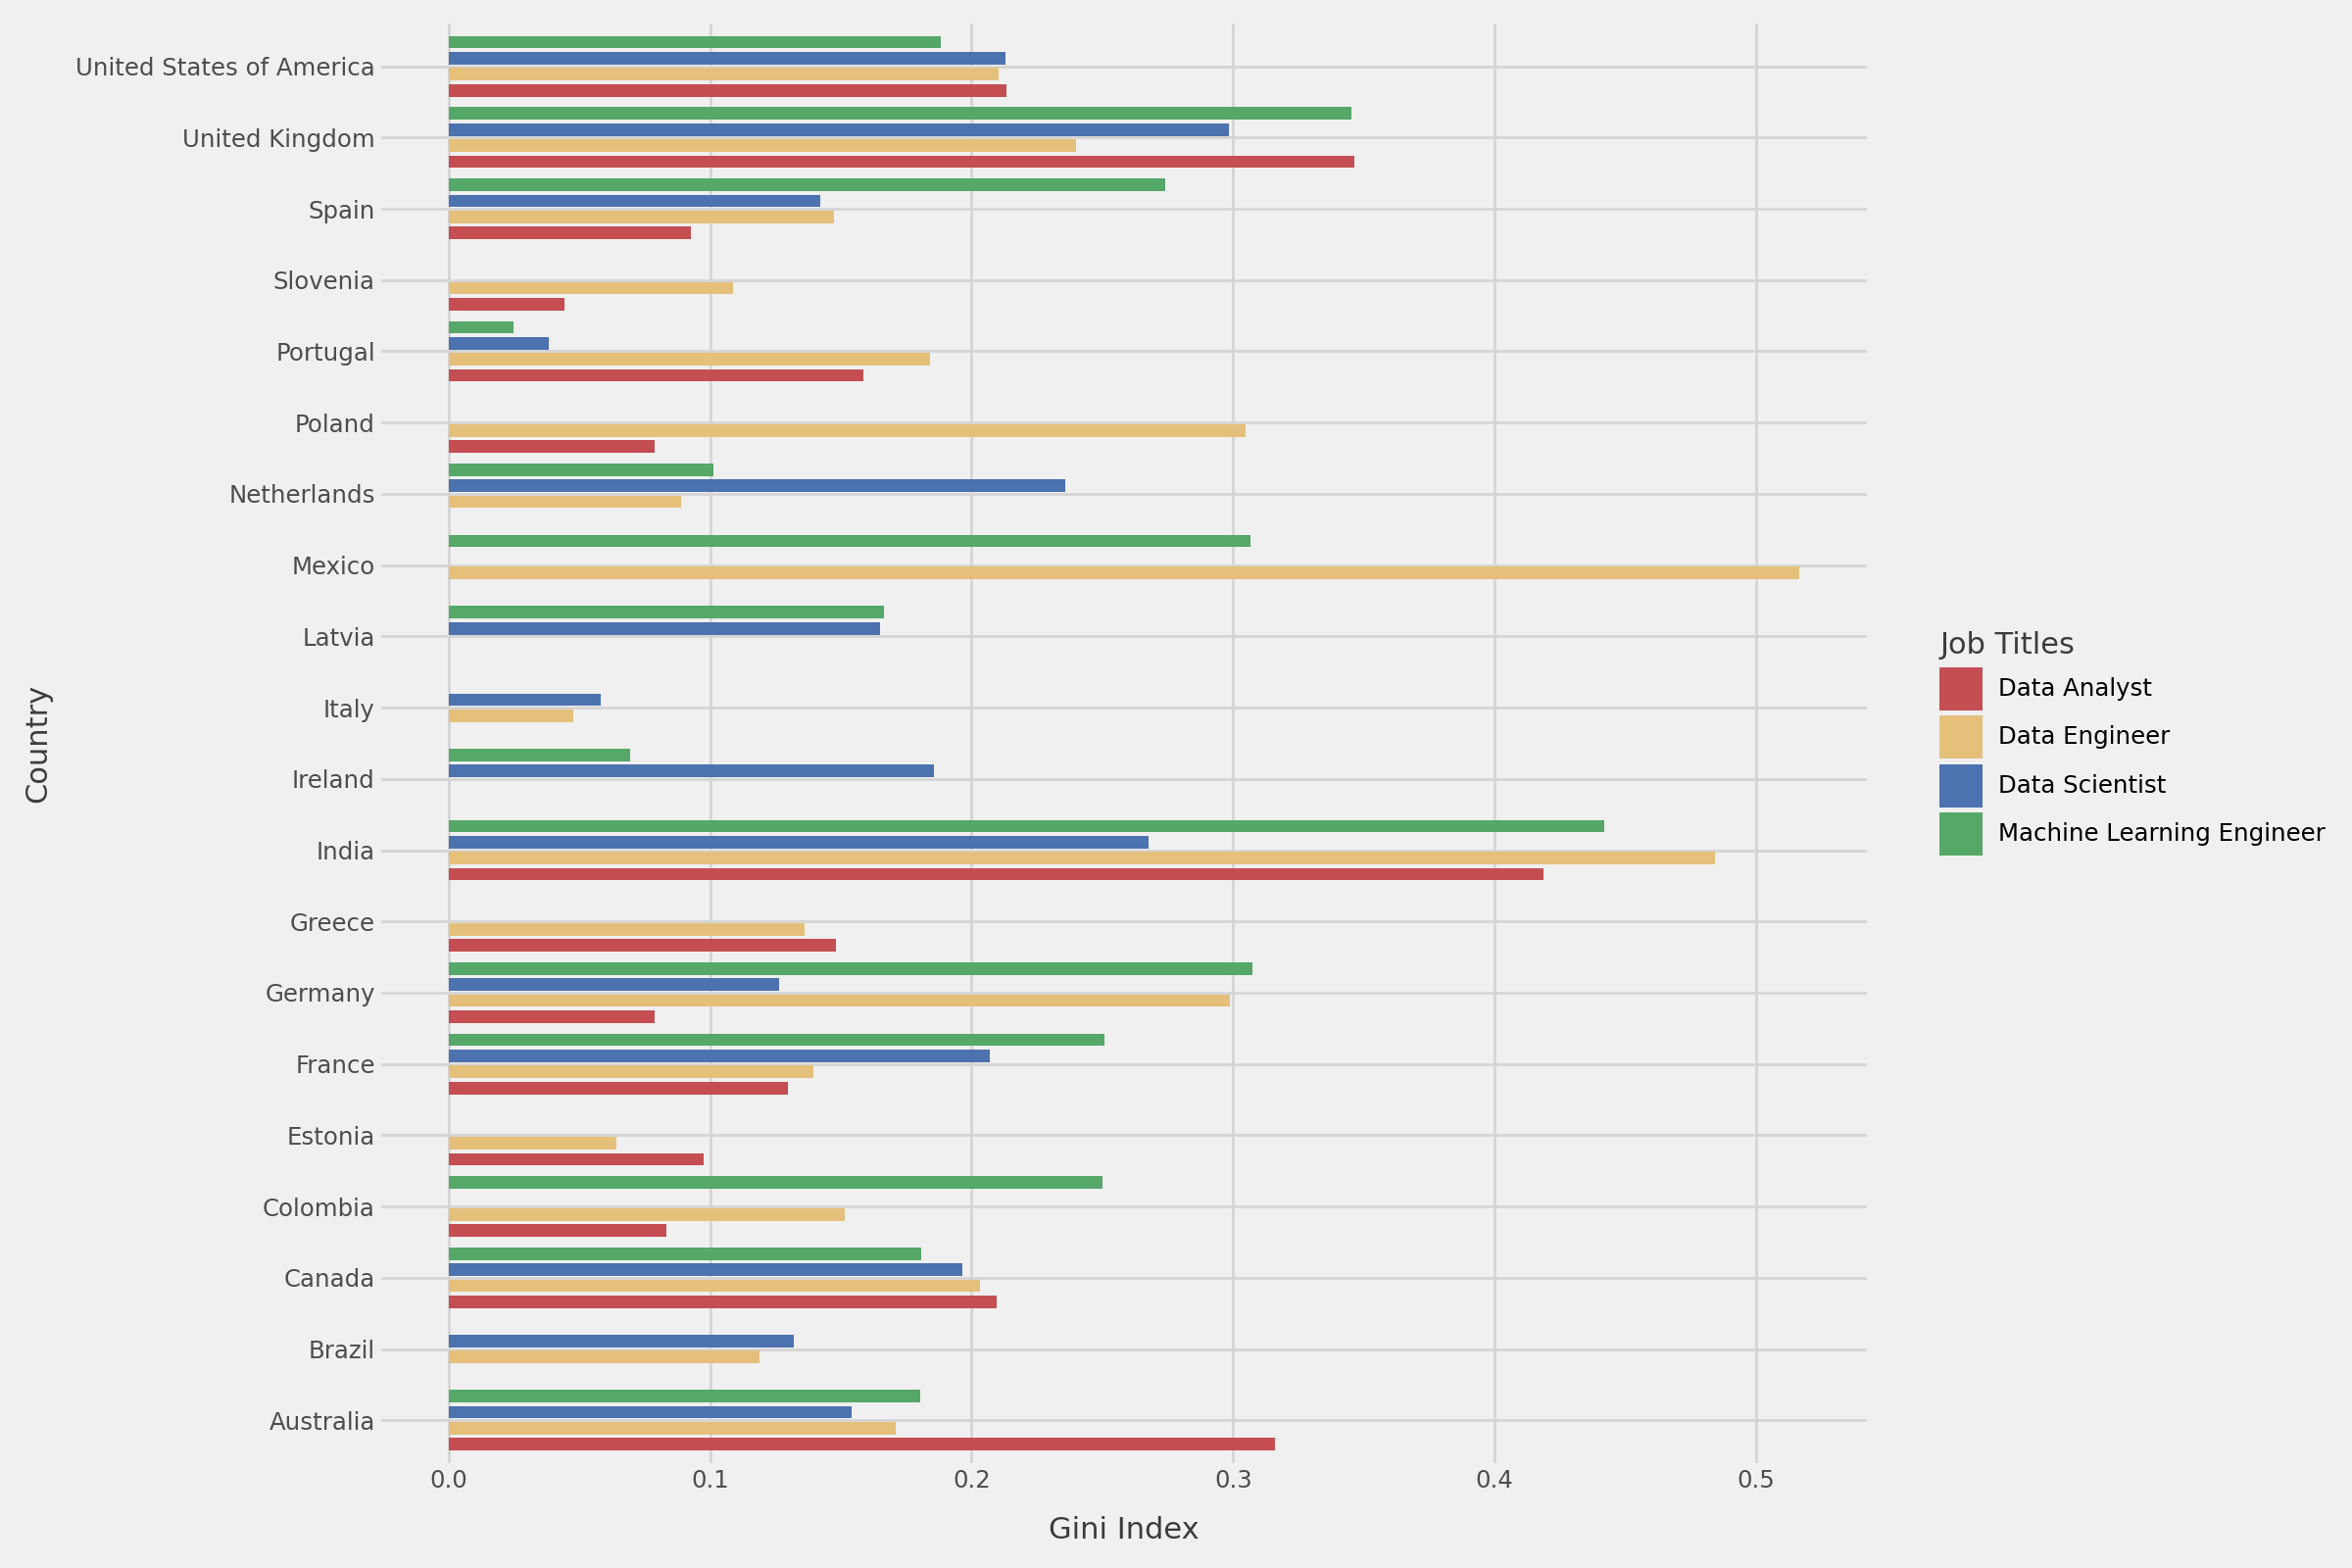

In [47]:
(
    ggplot(gini_index, aes(x='country', y = 'gini_index', fill = 'job_title')) # Map x: company location, y: Gini index
    + geom_col(position=position_dodge(width=0.9), # Adjust position for dodging
               width=0.7,# Set column width
               na_rm=True) # Remove missing values
    + scale_fill_manual(cols, # Set custom fill colors
                        labels = lambda l: [x.title() for x in l]) # Format fill labels
    + coord_flip() # Flip coordinates
    + theme(figure_size=(12,8)) # Customize theme
    + labs(x = "Country",y = "Gini Index", fill = "Job Titles") # Add labels
)